In [1]:
## aim to predict the escalation of users using RNN and compare with other baseline classfiers

In [64]:
import pandas as pd
import numpy 
import os
import git
import pickle
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot
import numpy as np
import re
from collections import Counter
import gensim
# from gensim import corpora
import os
import networkx as nx
import ast
import xgboost
from xgboost import XGBClassifier
tqdm.pandas()

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

In [3]:
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import SGD
from keras.models import Model, Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Reshape
from keras.layers import Average
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

Using TensorFlow backend.


In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from tqdm.auto import tqdm
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score

In [5]:
import os
import sys
module_path = os.path.abspath(os.path.join('..','..','src','preprocess','escalation'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
# from escalation import escalation

In [7]:
## Read the labelled files and the poly_user
def get_git_root(path):
	git_repo = git.Repo(path, search_parent_directories=True)
	git_root = git_repo.git.rev_parse("--show-toplevel")
	return git_root

In [8]:
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [9]:
# setup env
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/drew_william2345/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/drew_william2345/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
## tokenize the text..
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer as keras_Tokenizer
from sklearn.metrics import classification_report
from keras.layers import Embedding
from nltk.tokenize import TweetTokenizer
tweet_tknzr = TweetTokenizer()
def get_tokens(sentence):
#     tokens = nltk.word_tokenize(sentence)  # now using tweet tokenizer
    tokens = tweet_tknzr.tokenize(sentence)
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if (token not in stopwords and len(token) > 1)] ## remove punctuations
    tokens = [get_lemma(token) for token in tokens]
    return (tokens)

In [11]:
def clean_text(text):
    text = re.sub(r'(https?://\S+)', "", text) ## remove url
    text = re.sub(r'(\@\w+)', "author",text)   ## remove @ mentions with author
    text = re.sub(r'(@)', "",text)             ## remove @ symbols
    text = re.sub(r'(author)',"",text)         ## remove author
    text = re.sub(r'(#)', "",text)             ## removing the hashtags signal 
    text = re.sub(r'(RT )', "",text)         ## remove the retweet info as they dont convey any information
    text = re.sub(r'(^:)',"",text)
    text = text.rstrip() 
    text = text.lstrip()
    return(text)

In [12]:
# create the word2vec dict from the dictionary
def get_word2vec(file_path):
    file = open(file_path, "r")
    if (file):
        word2vec = dict()
#         split = file.read().splitlines()
        for line in file:
            split_line = line.split(' ')
            key = split_line[0] # the first word is the key
            value = np.array([float(val) for val in split_line[1:]])
            word2vec[key] = value
        return (word2vec)
    else:
        print("invalid fiel path")

In [13]:
## get the embedding matrix weights:
from numpy import zeros
def get_embedding_matrix(keras_tkzr,word2vec):
    vocab_size = len(keras_tkzr.word_index) + 1
    embedding_matrix = zeros((vocab_size, 100))
    for word, i in keras_tkzr.word_index.items():
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return (embedding_matrix,vocab_size)

In [14]:
## pass to the bi-lstm model
def create_model(max_len,vocab_size,embedding_matrix):
    input = Input(shape=(max_len,))
    model = Embedding(vocab_size,100,weights=[embedding_matrix],input_length=max_len)(input)
    model =  Bidirectional (LSTM (100,return_sequences=True,dropout=0.50),merge_mode='concat')(model)
    model = TimeDistributed(Dense(100,activation='relu'))(model)
    model = Flatten()(model)
    model = Dense(100,activation='relu')(model)
    output = Dense(3,activation='softmax')(model)
    model = Model(input,output)
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    return model

In [15]:
## get the trained model
def train_evaluate_model(model,X_train,Y_train,X_test,Y_test):
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)
    print('Accuracy: %f' % (accuracy*100))
    Y_pred = model.predict(X_test)
    y_pred = np.array([np.argmax(pred) for pred in Y_pred])
    # scores = cross_val_score(model, X_test, Y_test, cv=5)
    print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')
    precision,recall,fscore,_ = precision_recall_fscore_support(Y_test,y_pred)
    return (model,precision,recall,fscore)

In [16]:
# so wil filter the users that does have weed tweet before 2016
# it return the mono user in that year
def get_mono(first_data,year):
    first_data["weed_first"] = pd.to_datetime(first_data["weed_first"])
    first_data["juul_first"] = pd.to_datetime(first_data["juul_first"])
    juul_users = list(first_data["userID"].loc[first_data["juul_first"].dt.year < year])
    print("juul_initial",len(juul_users))
    weed_users = list(first_data["userID"].loc[(first_data["weed_first"].dt.year < (year))])
    mono_users = list(set(juul_users) - set(weed_users))
    print("mono final",len(mono_users))
    return mono_users

In [17]:
## return the label of the poly users
def get_label_mono(tweets_data,first_data):  ## will change for year
    users = tweets_data.userID.unique()
    print("initial_users",len(users))
    poly_labelled =  list(first_data["userID"].loc[first_data.userID.isin(users) & (first_data.weed_first.isnull())]) ## all not null will become poly
    mono_labelled = (list(set(users) - set(poly_labelled)))   ## users that will change to poly in future year
    print("poly_users that will change",len(poly_labelled))
    print("users reaminin mono",len(mono_labelled))
    tweets_data["label"] = 0   ## initialize
    tweets_data.loc[tweets_data.userID.isin(poly_labelled),"label"] = 1  # all of the poly
    return(tweets_data)

In [18]:
def get_f1(Y_true,Y_pred):
    f_scores = precision_recall_fscore_support(Y_true,Y_pred)[2]
    supports = precision_recall_fscore_support(Y_true,Y_pred)[3]
    f1_num = 0
    for f_s,sup in zip(f_scores,supports):
        f1_num += (f_s * sup)
    f1 = f1_num / np.sum(supports)
    return(f1)

In [19]:
## join al the of the tweets for each user
def get_tweets_user(df):
    tqdm.pandas()
    df = df.groupby(['userID'])['tweetText'].progress_apply(lambda x: ','.join(x)).reset_index()
    return (df)

In [20]:
def get_lstm_model(max_len,vocab_size,dimension,embedding_matrix):
    max_len= max_len
    n_words = vocab_size
    print("creating model")
    input = Input(shape=(max_len,))
    model = Embedding(n_words,dimension,weights=[embedding_matrix],input_length=max_len)(input)
    model =  Bidirectional (LSTM (100,return_sequences=False,dropout=0.50),merge_mode='concat')(model)
    output = Dense(2,activation='sigmoid')(model)
    model = Model(input,output)
    # sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
    print("compiling the model")
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [21]:
## returns the emnbedding matrix for the lstm model
def get_embedding_matrix(vocab_size,dimension,embedding_file,keras_tkzr):
    word2vec = get_word2vec(embedding_file)
    from numpy import zeros
    embedding_matrix = zeros((vocab_size, dimension))
    for word, i in keras_tkzr.word_index.items():
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [22]:
top_dir = os.path.join(get_git_root(os.getcwd()))
input_dir = os.path.join(get_git_root(os.getcwd()),"input")
embeddings_dir  = os.path.join(get_git_root(os.getcwd()),"input","embeddings")
annotatted_dir = os.path.join(input_dir,"annotated_data")
classifier_dir = os.path.join(get_git_root(os.getcwd()),"models","classifier")
model_dir = os.path.join(get_git_root(os.getcwd()),"models")
poly_dir = os.path.join(model_dir,"poly_users")

In [23]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(top_dir)
if module_path not in sys.path:
    sys.path.append(module_path)
from src.preprocess.escalation import driver

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/drew_william2345/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/drew_william2345/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
poly_users = pickle.load(open(os.path.join(poly_dir,"poly_users.pkl"),"rb"))
regular_users = pickle.load(open(os.path.join(poly_dir,"regular_users.pkl"),"rb"))
mono_users = pickle.load(open(os.path.join(poly_dir,"mono_users.pkl"),"rb"))

In [27]:
first_data = pd.read_csv(os.path.join(input_dir,"user_first.csv"),lineterminator="\n")
juul_data = pd.read_csv(os.path.join(input_dir,"juul_data.csv"),lineterminator="\n")

In [28]:
## we taking data from juul and weed and not use the pattern
juul_data["tweetCreatedAt"] = pd.to_datetime(juul_data["tweetCreatedAt"])
# ## filter the juul data to capture just the regualr users
juul_data = juul_data.loc[juul_data.userID.isin(regular_users)]

# ## we keep only the regular usrs
first_data = first_data.loc[first_data.userID.isin(regular_users)]

## we look at weed first and juul first tweets
first_data["weed_first"] = pd.to_datetime(first_data["weed_first"])
first_data["juul_first"] = pd.to_datetime(first_data["juul_first"])

In [29]:
## so will train the classfier on the bucket data

In [30]:
## bucket the users in bucket :
#1 2015 - [2015-2018] 
#2 2015- 2016 - [17 - 18]
#3 2015 - 2017 - [18]

### functions for sequence LSTM

In [67]:
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")

In [68]:
def get_length(s):
    a = list(s.split())
    return(len(a))

In [69]:
## get window size
def get_window_size(df):
    tweet_count = df.groupby(by="userID")["tweetId"].count()
    tweet_count = tweet_count.reset_index()
    window = int(tweet_count.tweetId.quantile(0.95))
    return window

In [70]:
def get_max_length(df):
    ## max_length
    lengths = df["tweetText"].progress_apply(get_length)
    max_len = int(lengths.quantile(0.95))
    return (max_len)

In [71]:
def get_sequence(df,column,window,max_len):
    users = df.userID.unique()  # select the unique users
    X = []
    for user in tqdm(users):
        temp = list(df[column].loc[df.userID.isin([user])])
        if len(temp) < window:
            pad = np.zeros(((window-len(temp)),max_len))  # pad in case data is less than the window
            data = np.vstack((temp,pad))
        else:
            data = temp[:window]             ## truncate to be equal to window size
        X.append(data)
    return np.array(X)

In [72]:
def plot_coeff(k,model,feature_names):
    coef = (model.coef_.ravel()) 
    top_positive_coefficients = np.argsort(coef)[-k:]
    top_negative_coefficients = np.argsort(coef)[:k]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(17, 8))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * k), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * k), feature_names[top_coefficients], rotation=60, ha='right',fontsize= 20)
    plt.show()
    return coef

In [73]:
def get_lstm_tweet_seq(max_len,window,vocab_size,embedding_matrix):
    max_len= max_len
    n_words = vocab_size
    Dimension = 100
    input = Input(shape=(window,max_len,))
    model = Embedding(n_words,Dimension,weights=[embedding_matrix],input_length=(window,max_len,))(input)
    model = Reshape(target_shape=(window,(max_len*Dimension)))(model)
    # model =  Bidirectional (LSTM (100,return_sequences=True,dropout=0.25),merge_mode='concat')(model)
    model =  Bidirectional (LSTM (100,return_sequences=False,dropout=0.25),merge_mode='concat')(model)
    output = Dense(2,activation='sigmoid')(model)
    model = Model(input,output)
    # sgd = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
    print("compiling the model")
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [74]:
from keras.callbacks import Callback
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_predict = np.array([np.argmax(value) for value in val_predict])
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print ("— val_f1: %f — val_precision: %f — val_recall %f"%(_val_f1, _val_precision, _val_recall))
        print('  Classification Report:\n',classification_report(val_targ,val_predict),'\n')
        return

metrics = Metrics()

In [75]:
def training_plot(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [76]:
## return claean dataframe with sequneced X,y ; and embeddign matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
tqdm.pandas() 
def prepare_data_rnn(df,users_labelled):
    dimension = 100
    
    df = df[["userID","tweetText","tweetId"]]
    ## data
    print("length of the data",len(df))
    
    print("users",len(df.userID.unique()))
    
    ## cleaning 
    print("cleanining the data")
    tqdm.pandas()
    df["tweetText"] = df["tweetText"].progress_apply(clean_text)
    df["tweetText"] = df["tweetText"].progress_apply(get_tokens).str.join(" ")
    
    ## print winodow , max_len for analysis purpose
    max_len = get_max_length(df)
    print("max_length",max_len)
    window= get_window_size(df)
    print("window_size",window)

    ## prepare the tokenizer
    print("preparing the tokenizer")
    keras_tkzr = keras_Tokenizer()
    keras_tkzr.fit_on_texts(df["tweetText"])
    vocab_size = len(keras_tkzr.word_index) + 1
    print("vocalb",vocab_size)
    
    ## embedding matrix
    print("creating glove embeddign matrix")
    embedding_matrix = get_embedding_matrix(vocab_size,dimension,embedding_file,keras_tkzr) ## tokenizer contains the vocalb info

    ## encoding the docs
    print("encoding the data")
    encoded_docs = keras_tkzr.texts_to_sequences(df["tweetText"])
    df["encoded_docs"] = list(pad_sequences(encoded_docs, maxlen=max_len, padding='post'))
    
    ## undersampling based on the users_labelled file
    users = np.array(list(users_labelled["userID"])).reshape(-1,1)
    label = list(users_labelled["label"])
    
    print("total users before",len(users))
    pos_samples = [ele for ele in label if ele==1]
    print("length of positive samples before",len(pos_samples))
    rus = RandomUnderSampler(random_state=0)
    rus.fit(users,label)
    users_sample, label_samples = rus.fit_sample(users,label)
    users_sample = list(users_sample)  ## changing the shape
    
    ## pos samples after
    pos_samples = [ele for ele in label_samples if ele==1]
    print("length of positive samples after",len(pos_samples))
    print("total users after",len(users_sample))
    
    # adjusting the dataframe based on random undersampling
    print("before data",len(df))
    print("users before",len(df.userID.unique()))
    df = df.loc[df.userID.isin(users_sample)]   ## under sampled data
    print("after data",len(df))
    print("after users",len(df.userID.unique()))
    
    ## getting output label 
    print("getting the output label")
    temp = df.groupby(by="userID")["tweetId"].count().reset_index()
    ## join with the users_labelled data to preserve the order
    temp = temp.join(users_labelled.set_index("userID"),on="userID",how="inner")
    y = list(temp["label"])
    
    ## get sequnced data (X)
    print("sequencing data")
    X = get_sequence(df,"encoded_docs",window,max_len)
    
    ## return sequenced data for reference
    agg_data = df.groupby(by="userID")["tweetText"].agg(';'.join).reset_index()
    agg_data = agg_data.join(users_labelled.set_index("userID"),on="userID",how="inner").reset_index(drop=True)
    return (agg_data,X,y,embedding_matrix,window,max_len,vocab_size)

In [77]:
# return trained model and F1 score 
def run_sequence_model(X,y,embedding_matrix,window,max_len,vocab_size,epoch,metrics,weights=None):
    dimension = 100
    ## split the data
    print("train-test split")
    X_train,X_test,Y_train,Y_test  = train_test_split(X, np.array(y),test_size =0.20,random_state= 4,shuffle=True ,
                                                      stratify= np.array(y))
    
    X_train,X_val,Y_train,Y_val  = train_test_split(X_train, Y_train,test_size =0.25,random_state= 4,shuffle=True ,
                                                     stratify= Y_train)
                                 
    print("X-train",X_train.shape)
    print("X-test",X_test.shape)
    
    
    print("creating lstm model")
    model = get_lstm_tweet_seq(max_len,window,vocab_size,embedding_matrix)
    
    print("adjusting the weights for each class")
    print(weights)
    print("training the model with balance dataset")
    
    history = model.fit(X_train,Y_train,validation_data = (X_val,Y_val) , nb_epoch = epoch, 
                        verbose = 1,batch_size=32,class_weight= weights,callbacks=[metrics])

    ##plotting trainin validation - no point as we dont want ot look at accuarcy
    training_plot(history)
    
    print("generating classfication report")
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)
    print('Accuracy: %f' % (accuracy*100))
    ## lstm model
    temp = model.predict(X_test)
    y_pred = [np.argmax(value) for value in temp] 
    print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')
    f1_score = (get_f1(Y_test,y_pred))
    
    print("job finished")
    return (model,f1_score)

In [78]:
def prepare_data_lstm(df,users_labelled):
    dimension = 100
    
    df = df[["userID","tweetText","tweetId"]]
    ## data
    print("length of the data",len(df))
    
    print("users",len(df.userID.unique()))
    
    ## cleaning 
    print("cleanining the data")
    tqdm.pandas()
    df["tweetText"] = df["tweetText"].progress_apply(clean_text)
    df["tweetText"] = df["tweetText"].progress_apply(get_tokens).str.join(" ")
    
    ## print winodow , max_len for analysis purpose
    max_len = get_max_length(df)
    print("max_length",max_len)

    ## undersampling based on the users_labelled file
    users = np.array(list(users_labelled["userID"])).reshape(-1,1)
    label = list(users_labelled["label"])
    
    print("total users before",len(users))
    pos_samples = [ele for ele in label if ele==1]
    print("length of positive samples before",len(pos_samples))
    rus = RandomUnderSampler(random_state=0)
    rus.fit(users,label)
    users_sample, label_samples = rus.fit_sample(users,label)
    users_sample = list(users_sample)  ## changing the shape
    
    ## pos samples after
    pos_samples = [ele for ele in label_samples if ele==1]
    print("length of positive samples after",len(pos_samples))
    print("total users after",len(users_sample))
    
    # adjusting the dataframe based on random undersampling
    print("before data",len(df))
    print("users before",len(df.userID.unique()))
    df = df.loc[df.userID.isin(users_sample)]   ## under sampled data
    print("after data",len(df))
    print("after users",len(df.userID.unique()))
    
    data = df.groupby(by="userID")["tweetText"].apply(lambda x: "%s" % ' '.join(x)).reset_index()
    data = data.join(users_labelled.set_index("userID"),on="userID",how="inner")
    
    ## prepare the tokenizer
    print("preparing the tokenizer")
    keras_tkzr = keras_Tokenizer()
    keras_tkzr.fit_on_texts(data["tweetText"])
    vocab_size = len(keras_tkzr.word_index) + 1
    print("vocalb",vocab_size)
    
    ## embedding matrix
    print("creating glove embeddign matrix")
    embedding_matrix = get_embedding_matrix(vocab_size,dimension,embedding_file,keras_tkzr) ## tokenizer contains the vocalb info

    ## encoding the docs
    print("encoding the data")
    encoded_docs = keras_tkzr.texts_to_sequences(data["tweetText"])
    X = (pad_sequences(encoded_docs, maxlen=max_len, padding='post'))
    
    y = np.array(list(data["label"]))
    
    print("X",X.shape)
    print("y",y.shape)
    
    return (data,X,y,embedding_matrix,max_len,vocab_size)

In [79]:
def run_lstm_model(X,y,embedding_matrix,max_len,vocab_size,dimension,epoch,metrics,weights=None):
    ## split the data
    print("train-test split")
    X_train,X_test,Y_train,Y_test  = train_test_split(X, y,test_size =0.20,random_state= 4,shuffle=True ,stratify= y)
    
    X_train,X_val,Y_train,Y_val  = train_test_split(X_train, Y_train,test_size =0.25,random_state= 4,shuffle=True ,
                                                     stratify= Y_train)
                                 
    print("X-train",X_train.shape)
    print("X-test",X_test.shape)
    
    
    print("creating lstm model")
    model = get_lstm_model(max_len,vocab_size,dimension,embedding_matrix)
    
    print("training the model with balance dataset")
    
    history = model.fit(X_train,Y_train,validation_data = (X_val,Y_val) , nb_epoch = epoch, 
                        verbose = 1,batch_size=32,class_weight= weights,callbacks=[metrics])

    ##plotting trainin validation - no point as we dont want ot look at accuarcy
    training_plot(history)
    
    print("generating classfication report")
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)
    print('Accuracy: %f' % (accuracy*100))
    ## lstm model
    temp = model.predict(X_test)
    y_pred = [np.argmax(value) for value in temp] 
    print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')
    f1_score = (get_f1(Y_test,y_pred))
    
    print("job finished")
    return (f1_score,y_pred,model)

## Sequential prediction using LSTM and baseline classfier for 2018 data

## Month level

In [26]:
## sequence of tweets for user
## output prediction would be for the users so teh lstm layer would need to flatten to a single user..

## poly_turned : if users tweets weed after september (>=9 months) 
## remain_mono :
## seeing the data in different buckets:
#   1  [jan - mar )
#   2  [mar- may )
#   3  [May - july]
#   4  [July - sept]

## use lstm
## use svm
## majority
## xg boost

In [97]:
## so we are taking the users that start on Jan 2018 and change in the month of september, 
# and we change the threshold of input data to see how accurately we can predict that

In [28]:
## input data :juul_data 
juul_data = pd.read_csv(os.path.join(input_dir,"juul_data.csv"),lineterminator="\n")
juul_data["tweetCreatedAt"] = pd.to_datetime(juul_data["tweetCreatedAt"])
juul_data = juul_data.loc[juul_data.userID.isin(regular_users)]

# ## look at the weed first and juul_first tweet
first_data = pd.read_csv(os.path.join(input_dir,"user_first.csv"),lineterminator="\n")
first_data = first_data.loc[first_data.userID.isin(regular_users)]  # reg users
first_data["weed_first"] = pd.to_datetime(first_data["weed_first"])
first_data["juul_first"] = pd.to_datetime(first_data["juul_first"])

In [29]:
## removing the rewteet text column completely
ids_ = juul_data.loc[juul_data['retweetText'].notnull()]["tweetId"]
juul_data.loc[juul_data.tweetId.isin(ids_),"tweetText"] = juul_data.loc[juul_data.tweetId.isin(ids_)]["retweetText"]
juul_data = juul_data.drop(["hashtags","retweetText"],axis=1)
len(juul_data) ## 1353987 (sanity check)

1353987

In [30]:
len(juul_data) ## 1353987
len(juul_data.userID.unique()) ## 673724  reg users

673724

In [31]:
pd.isnull(list(first_data.loc[first_data.userID == 2534]["weed_first"])[0])

True

In [32]:
## get the users who start at jan 2018 
users_2018 = list(first_data["userID"][ 
    (first_data.juul_first.dt.year == 2018)
    & ((first_data.weed_first.dt.year == 2018) | (pd.isnull(first_data.weed_first)))
    & (first_data.juul_first.dt.month== 1)   ## selecting 2018, Jan data
    & (((first_data.weed_first.dt.date) > (first_data.juul_first.dt.date)) | (pd.isnull(first_data.weed_first)))
    & ((first_data.weed_first.dt.month >= 9) | (pd.isnull(first_data.weed_first)))]) # users who will change after september

poly_lbl = list(first_data["userID"].loc[(first_data.juul_first.dt.year == 2018)  
                                        & (first_data.juul_first.dt.month== 1) 
                                        & ((first_data.weed_first.dt.date) > (first_data.juul_first.dt.date))
                                        & ((first_data.weed_first.dt.month >= 9))
                                        & ((first_data.weed_first.dt.year == 2018))
                                        ])
                                            ## users that will change
print("total users", len(users_2018))
print("users will change",len(poly_lbl))

total users 10760
users will change 929


In [33]:
data_2018 = juul_data.loc[juul_data.userID.isin(users_2018) & (juul_data.tweetCreatedAt.dt.year == 2018)]
print("total data", len(data_2018))
print("users",len(data_2018.userID.unique()))

## sanity check -- all users start in 2018 year..
data_2018 = juul_data.loc[juul_data.userID.isin(users_2018)]
print("total data", len(data_2018))
print("users",len(data_2018.userID.unique()))

total data 24018
users 10760
total data 24018
users 10760


In [34]:
## get label - they reamain same for this task as the no of users, we only change the tweets data
users_ = data_2018.userID.unique()
users_labelled = pd.DataFrame(users_,columns=["userID"])
users_labelled["label"] = 0  ## initialize
users_labelled.loc[users_labelled.userID.isin(poly_lbl) , "label"] = 1
len(users_labelled.loc[users_labelled.label == 1])  ## sanity check

929

In [35]:
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")


In [36]:
bucket_data = []

In [37]:
#   1  [jan - mar )
bucket_ = data_2018.loc[(data_2018.tweetCreatedAt.dt.month >= 1) & (data_2018.tweetCreatedAt.dt.month < 3)] ## first
print("length of the data",len(bucket_))
print("total users",len(bucket_.userID.unique()))
bucket_data.append(bucket_)

length of the data 13087
total users 10760


In [38]:
#   2  [mar- may )
bucket_ = data_2018.loc[(data_2018.tweetCreatedAt.dt.month >= 1) & (data_2018.tweetCreatedAt.dt.month < 5)] ## first
print("length of the data",len(bucket_))
print("total users",len(bucket_.userID.unique()))
bucket_data.append(bucket_)

length of the data 15477
total users 10760


In [39]:
#   3  [May - july]
bucket_ = data_2018.loc[(data_2018.tweetCreatedAt.dt.month >= 1) & (data_2018.tweetCreatedAt.dt.month < 7)] ## first
print("length of the data",len(bucket_))
print("total users",len(bucket_.userID.unique()))
bucket_data.append(bucket_)

length of the data 18204
total users 10760


In [40]:
#   4  [July - sept]
bucket_ = data_2018.loc[(data_2018.tweetCreatedAt.dt.month >= 1) & (data_2018.tweetCreatedAt.dt.month < 9)] ## first
print("length of the data",len(bucket_))
print("total users",len(bucket_.userID.unique()))
bucket_data.append(bucket_)

length of the data 20383
total users 10760


In [41]:
len(bucket_data)

4

********************
length of users 10760
length of the data 13087
users 10760
cleanining the data


max_length 45
window_size 2
preparing the tokenizer
vocalb 6711
creating glove embeddign matrix
encoding the data
total users before 10760
length of positive samples before 929
length of positive samples after 929
total users after 1858
before data 13087
users before 10760
after data 2410
after users 1858
getting the output label
sequencing data


train-test split
X-train (1114, 2, 45)
X-test (372, 2, 45)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2, 45)             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 2, 45, 100)        671100    
_________________________________________________________________
reshape_3 (Reshape)          (None, 2, 4500)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               3680800   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 402       
Total params: 4,352,302
Trainable params: 4,352,302
Non-trainable params: 0
_________________________________________________________________
None
adjusting the weights for ea

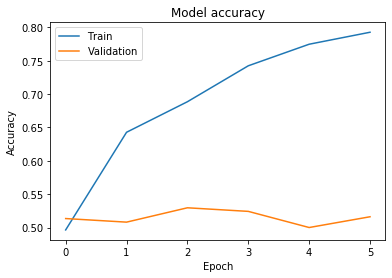

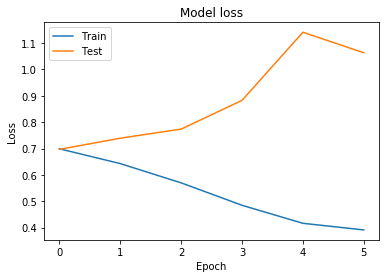

generating classfication report
Accuracy: 53.494624
  Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.50      0.52       186
           1       0.53      0.57      0.55       186

    accuracy                           0.53       372
   macro avg       0.54      0.53      0.53       372
weighted avg       0.54      0.53      0.53       372
 

job finished
********************
length of users 10760
length of the data 15477
users 10760
cleanining the data


max_length 45
window_size 3
preparing the tokenizer
vocalb 7408
creating glove embeddign matrix
encoding the data
total users before 10760
length of positive samples before 929
length of positive samples after 929
total users after 1858
before data 15477
users before 10760
after data 3021
after users 1858
getting the output label
sequencing data


train-test split
X-train (1114, 3, 45)
X-test (372, 3, 45)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3, 45)             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 3, 45, 100)        740800    
_________________________________________________________________
reshape_4 (Reshape)          (None, 3, 4500)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               3680800   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 402       
Total params: 4,422,002
Trainable params: 4,422,002
Non-trainable params: 0
_________________________________________________________________
None
adjusting the weights for ea

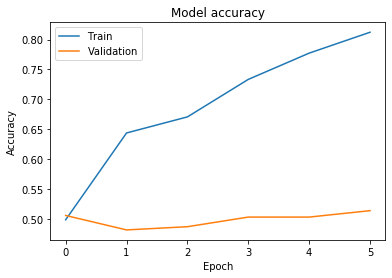

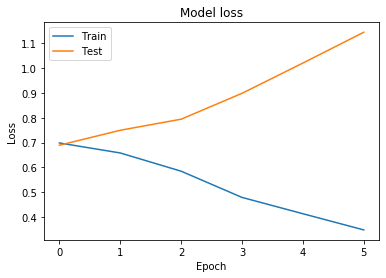

generating classfication report
Accuracy: 51.612903
  Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.41      0.46       186
           1       0.51      0.62      0.56       186

    accuracy                           0.52       372
   macro avg       0.52      0.52      0.51       372
weighted avg       0.52      0.52      0.51       372
 

job finished
********************
length of users 10760
length of the data 18204
users 10760
cleanining the data


max_length 45
window_size 4
preparing the tokenizer
vocalb 8146
creating glove embeddign matrix
encoding the data
total users before 10760
length of positive samples before 929
length of positive samples after 929
total users after 1858
before data 18204
users before 10760
after data 3767
after users 1858
getting the output label
sequencing data


train-test split
X-train (1114, 4, 45)
X-test (372, 4, 45)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 4, 45)             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 4, 45, 100)        814600    
_________________________________________________________________
reshape_5 (Reshape)          (None, 4, 4500)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 200)               3680800   
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 402       
Total params: 4,495,802
Trainable params: 4,495,802
Non-trainable params: 0
_________________________________________________________________
None
adjusting the weights for ea

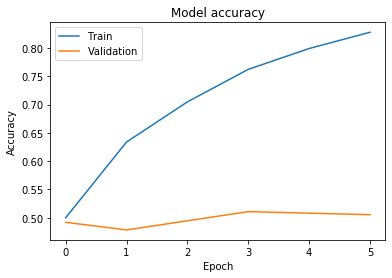

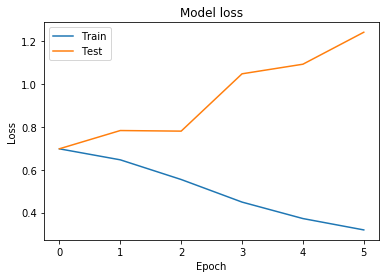

generating classfication report
Accuracy: 47.043011
  Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.49      0.48       186
           1       0.47      0.45      0.46       186

    accuracy                           0.47       372
   macro avg       0.47      0.47      0.47       372
weighted avg       0.47      0.47      0.47       372
 

job finished
********************
length of users 10760
length of the data 20383
users 10760
cleanining the data


max_length 45
window_size 5
preparing the tokenizer
vocalb 8797
creating glove embeddign matrix
encoding the data
total users before 10760
length of positive samples before 929
length of positive samples after 929
total users after 1858
before data 20383
users before 10760
after data 4389
after users 1858
getting the output label
sequencing data


train-test split
X-train (1114, 5, 45)
X-test (372, 5, 45)
creating lstm model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 5, 45)             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 5, 45, 100)        879700    
_________________________________________________________________
reshape_6 (Reshape)          (None, 5, 4500)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200)               3680800   
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 402       
Total params: 4,560,902
Trainable params: 4,560,902
Non-trainable params: 0
_________________________________________________________________
None
adjusting the weights for ea

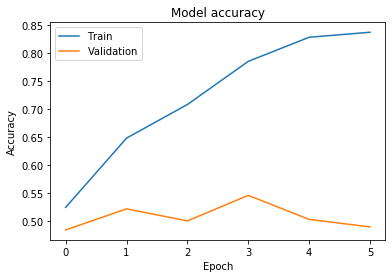

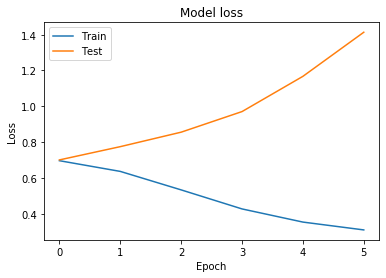

generating classfication report
Accuracy: 51.881720
  Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.38      0.44       186
           1       0.51      0.66      0.58       186

    accuracy                           0.52       372
   macro avg       0.52      0.52      0.51       372
weighted avg       0.52      0.52      0.51       372
 

job finished


In [63]:
## with sequencing
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")
sequence_lstm_scores = []
sequence_lstm_models = []
cleaned_data_list = []
for data in bucket_data:
    print("********************")
    print("length of users",len(users_labelled))
    df,X,y,embedding_matrix,window,max_len,vocalb_size  = prepare_data_rnn(data,users_labelled)
    model,score = run_sequence_model(X,y,embedding_matrix,window,max_len,vocalb_size,epoch= 6,metrics=metrics)
    sequence_lstm_scores.append(score)
    sequence_lstm_models.append(model)
    cleaned_data_list.append(df)

********************
length of users 10760
length of the data 13087
users 10760
cleanining the data


max_length 45
total users before 10760
length of positive samples before 929
length of positive samples after 929
total users after 1858
before data 13087
users before 10760
after data 2410
after users 1858
preparing the tokenizer
vocalb 2825
creating glove embeddign matrix
encoding the data
X (1858, 45)
y (1858,)
train-test split
X-train (1114, 45)
X-test (372, 45)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 45)                0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 45, 100)           282500    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 45, 200)           160800    
_________________________________________________________________
flatten_1 (Flatten)          (None, 9000)       

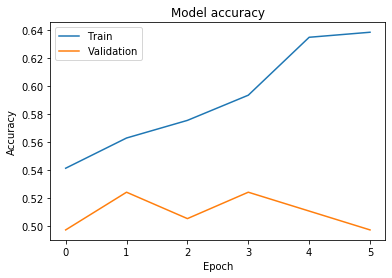

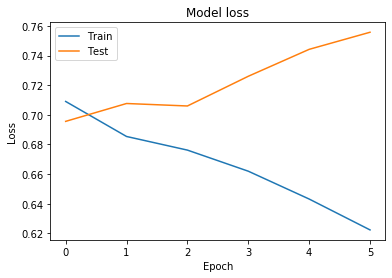

generating classfication report
Accuracy: 59.408602
  Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.52      0.56       186
           1       0.58      0.67      0.62       186

    accuracy                           0.59       372
   macro avg       0.60      0.59      0.59       372
weighted avg       0.60      0.59      0.59       372
 

job finished
********************
length of users 10760
length of the data 15477
users 10760
cleanining the data


max_length 45
total users before 10760
length of positive samples before 929
length of positive samples after 929
total users after 1858
before data 15477
users before 10760
after data 3021
after users 1858
preparing the tokenizer
vocalb 3254
creating glove embeddign matrix
encoding the data
X (1858, 45)
y (1858,)
train-test split
X-train (1114, 45)
X-test (372, 45)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 45)                0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 45, 100)           325400    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 45, 200)           160800    
_________________________________________________________________
flatten_2 (Flatten)          (None, 9000)       

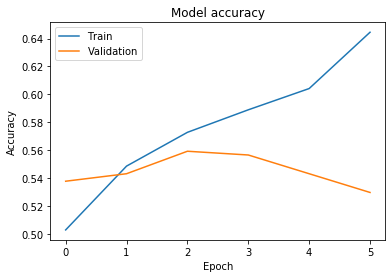

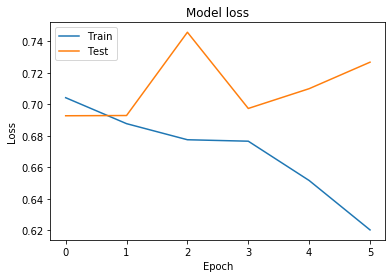

generating classfication report
Accuracy: 56.720430
  Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.48      0.53       186
           1       0.56      0.65      0.60       186

    accuracy                           0.57       372
   macro avg       0.57      0.57      0.56       372
weighted avg       0.57      0.57      0.56       372
 

job finished
********************
length of users 10760
length of the data 18204
users 10760
cleanining the data


max_length 45
total users before 10760
length of positive samples before 929
length of positive samples after 929
total users after 1858
before data 18204
users before 10760
after data 3767
after users 1858
preparing the tokenizer
vocalb 3753
creating glove embeddign matrix
encoding the data
X (1858, 45)
y (1858,)
train-test split
X-train (1114, 45)
X-test (372, 45)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 45)                0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 45, 100)           375300    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 45, 200)           160800    
_________________________________________________________________
flatten_3 (Flatten)          (None, 9000)       

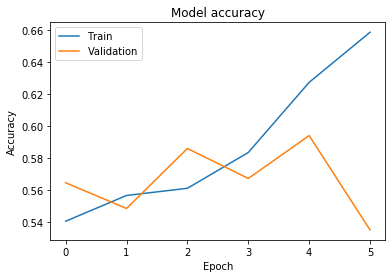

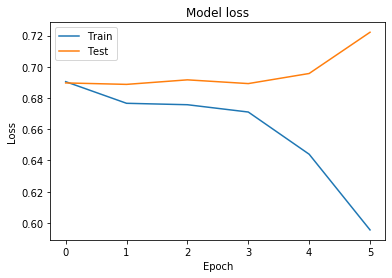

generating classfication report
Accuracy: 61.021505
  Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.56      0.59       186
           1       0.60      0.66      0.63       186

    accuracy                           0.61       372
   macro avg       0.61      0.61      0.61       372
weighted avg       0.61      0.61      0.61       372
 

job finished
********************
length of users 10760
length of the data 20383
users 10760
cleanining the data


max_length 45
total users before 10760
length of positive samples before 929
length of positive samples after 929
total users after 1858
before data 20383
users before 10760
after data 4389
after users 1858
preparing the tokenizer
vocalb 4151
creating glove embeddign matrix
encoding the data
X (1858, 45)
y (1858,)
train-test split
X-train (1114, 45)
X-test (372, 45)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 45)                0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 45, 100)           415100    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 45, 200)           160800    
_________________________________________________________________
flatten_4 (Flatten)          (None, 9000)       

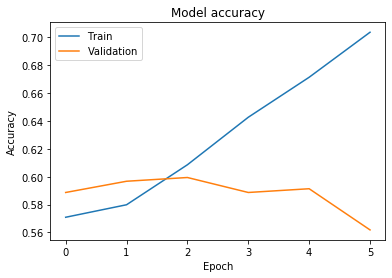

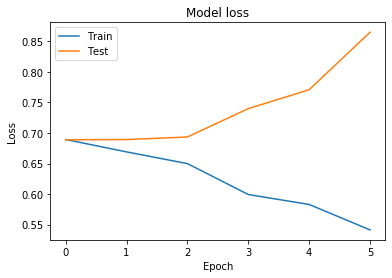

generating classfication report
Accuracy: 58.870968
  Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.41      0.50       186
           1       0.57      0.77      0.65       186

    accuracy                           0.59       372
   macro avg       0.60      0.59      0.57       372
weighted avg       0.60      0.59      0.57       372
 

job finished


In [65]:
## without sequencing lstm
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")
lstm_scores = []
lstm_models = []
cleaned_data_list = []
for data in bucket_data:
    print("********************")
    print("length of users",len(users_labelled))
    df,X,y,embedding_matrix,max_len,vocalb_size  = prepare_data_lstm(data,users_labelled)
    model,score = run_lstm_model(X,y,embedding_matrix,max_len,vocalb_size,dimension=100,epoch= 6,metrics=metrics)
    lstm_scores.append(score)
    lstm_models.append(model)
    cleaned_data_list.append(df)

In [229]:
dr = (cleaned_data_list)[3]
dr.loc[dr["tweetText"].apply(get_length) > 70]

,userID,tweetText,label
2,22363298,"i don't exactly know what a JUUL is but it's probably what ur man is putting around my neck ??????;crying in bed bc my cheating husband is brain dead and can't JUUL all over my tiddies anymore 😞; ok but is this what everyone talks about when they say JUUL? i don't know what it is; omg i just expanded the video and saw that u cited the fact that it's JUUL in the text...sorry to ask that redundant clarification before 😞;in the middle of working one of the single worst bar shifts i have ever worked last night, at one point i went to the backyard to hunt down someone who dipped on their tab and some random girl walks up and shoves a charger in my hand and says “CHARGE MY JUUL THXX” my goooooddddd; my ass is a temple i would not sully with a fucking JUUL",1
9,36601913,We will all get punished for juul i just don’t know how or when;I guess the bright side is the juul is very very clean now ... ya we washed our juul;Sometimes ... every so often ... you may find yourself blessed with a miracle when you don’t deserve one. Thing is ... we all need to remember that the universe may be cruel but is also serendipitously merciful. We found the juul.;My mom cleaned my apt but also slurped up all my juul juice.... trade offs,1
10,40020666,"I saw a dude charging a Juul using a Wii's USB port so that's how my Genesis is going;its weird mango chose his tag after that juul pod;I got drunk and bought a Juul last night so that's where I'm at in life;can I get juul to sponsor me for melee;shout out to this kid wearing a ""buchholz high school class of 2019"" shirt at this coffee shop ripping a juul as he counts quarters to buy a small coffee;Tbh I should just run up and steal this kid's juul. Like who is he gonna tattle to?;I know I talk a lot about the first juul rip of the day and how I like the crackle but goddamn it starts the day off right;i bought bootleg juul pods at a store next to my brunch and they're fuego;Just ripped the fattest Juul rip walking past an ABC7 camera so watch for that later",0
32,84390643,"I don’t do Juul. I have Jesus. ;The green light from the great gatsby was from a juul;disrespect is putting chapstick on and then hitting someone else’s juul right after;Yeah sex is cool and all, but have you ever ripped a Juul first thing in the morning?;ur mcm missed the birth of his first child because he was buying juul pods at the gas station across the street;When you rip the juul and hear mama comin down the hall...lmao ;Please bro lemme hit your juul bro please bro just one hit bro cmon bro lemme take a fat rip off your juul bro please bro I need your juul bro please lemme hit that juul bro please just one hit bro please bro I gottta have my juul fix bro please just one hit please bro juul me;what if the green light that gatsby saw across the water was daisy hitting her juul;Overheard in the quad, “yeah man, I almost forget I have a juul when I’m around her.” Ladies and gentlemen, chivalry is far from dead.;I was your juul but you ran out of pods - Rupi Kaur;saw this rando hitting his juul and the bond was made. bringing america together one cloud at a time ;WHY DID MY PARENTS LET ME ON THE INTERNET ALONE WHEN I WAS 8!!!!!! they broke me i didn't have to be like this.. i could be using a juul and listening to post malone with all the locals right now.... this life i live is just so messed up;Is 3 (three) juul hits a valid meal replacement yes or no;them: “you need to have more fruit” me: *gets mango juul pods instead of mint* “that should do it”;the green light from great gatsby was from a juul;The green light from Gatsby was just Daisy’s juul;this dude just hit a weed vape and a juul at the same time and called it a “silicon valley spliff” oh my god;*at thanksgiving dinner Mom: so your bf is a professional jeweler, that’s so interesting Daughter: no he’s a professional juuler Me: rips juul, blows out smoke to form the word “nice”;Today's list: ✅wake up rip juul ✅lip sync to Drake's new album a

#### baseline models

In [66]:
svm_scores = []
svm_models= []
rf_models= []
rf_scores = []
maj_scores = []
tfidf_list = []
xgb_scores = []
xgb_models = []
for data in bucket_data:
    print("********************")
    print("length of users",len(users_labelled))
    final = run_baslines(data,users_labelled)
    svm_model,svm_score = final["svm"]
    rf_model, rf_score = final["rf"]
    xgb_model,xgb_score = final["xg_boost"]
    tf_idf = final["tf-idf"]
    maj_score = final["maj"]
    tfidf_list.append(tf_idf)
    svm_scores.append(svm_score)
    svm_models.append(svm_model)
    rf_scores.append(rf_score)
    rf_models.append(rf_model)
    xgb_scores.append(xgb_score)
    xgb_models.append(xgb_model)
    maj_scores.append(maj_score)

********************
length of users 10760


preparing the tokenizer
downsampling
downsampled data length (1858, 6621)
train-test split
training the models
svm
[LibLinear]rf
xgBoost
predicting scores
svm
  Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.53      0.55       186
           1       0.57      0.62      0.59       186

    accuracy                           0.58       372
   macro avg       0.58      0.58      0.57       372
weighted avg       0.58      0.58      0.57       372
 

random_forest
  Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.64      0.61       186
           1       0.60      0.54      0.57       186

    accuracy                           0.59       372
   macro avg       0.59      0.59      0.59       372
weighted avg       0.59      0.59      0.59       372
 

xgboost
  Classification Report:
               precision    recall  f1-score   support

           0       0.57     

preparing the tokenizer
downsampling
downsampled data length (1858, 7315)
train-test split
training the models
svm
[LibLinear]rf
xgBoost
predicting scores
svm
  Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.63      0.59       186
           1       0.58      0.51      0.54       186

    accuracy                           0.57       372
   macro avg       0.57      0.57      0.57       372
weighted avg       0.57      0.57      0.57       372
 

random_forest
  Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.82      0.66       186
           1       0.65      0.33      0.44       186

    accuracy                           0.58       372
   macro avg       0.60      0.58      0.55       372
weighted avg       0.60      0.58      0.55       372
 

xgboost
  Classification Report:
               precision    recall  f1-score   support

           0       0.56     

preparing the tokenizer
downsampling
downsampled data length (1858, 8047)
train-test split
training the models
svm
[LibLinear]rf
xgBoost
predicting scores
svm
  Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.62      0.60       186
           1       0.59      0.56      0.58       186

    accuracy                           0.59       372
   macro avg       0.59      0.59      0.59       372
weighted avg       0.59      0.59      0.59       372
 

random_forest
  Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.84      0.70       186
           1       0.74      0.44      0.55       186

    accuracy                           0.64       372
   macro avg       0.67      0.64      0.62       372
weighted avg       0.67      0.64      0.62       372
 

xgboost
  Classification Report:
               precision    recall  f1-score   support

           0       0.58     

preparing the tokenizer
downsampling
downsampled data length (1858, 8694)
train-test split
training the models
svm
[LibLinear]rf
xgBoost
predicting scores
svm
  Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.66      0.62       186
           1       0.61      0.54      0.58       186

    accuracy                           0.60       372
   macro avg       0.60      0.60      0.60       372
weighted avg       0.60      0.60      0.60       372
 

random_forest
  Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.85      0.70       186
           1       0.73      0.41      0.53       186

    accuracy                           0.63       372
   macro avg       0.66      0.63      0.61       372
weighted avg       0.66      0.63      0.61       372
 

xgboost
  Classification Report:
               precision    recall  f1-score   support

           0       0.59     

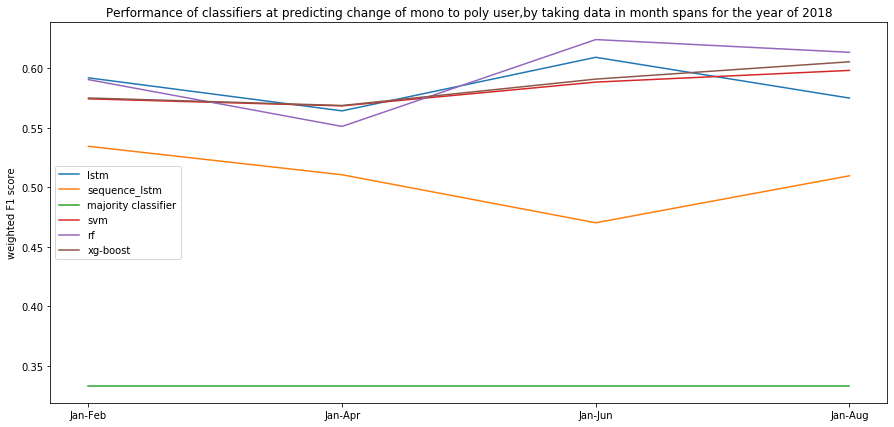

In [67]:
plt.figure(figsize=(15,7))
months = ["Jan-Feb","Jan-Apr","Jan-Jun","Jan-Aug"]
plt.plot(months,lstm_scores,label="lstm")
plt.plot(months,sequence_lstm_scores,label="sequence_lstm")
plt.plot(months,(4*[maj_score]),label="majority classifier")
plt.plot(months,svm_scores,label="svm")
plt.plot(months,rf_scores,label="rf")
plt.plot(months,xgb_scores,label="xg-boost")
plt.title("Performance of classifiers at predicting change of mono to poly user,by taking data in month spans for the year of 2018")
plt.ylabel("weighted F1 score")
plt.legend()
plt.show()

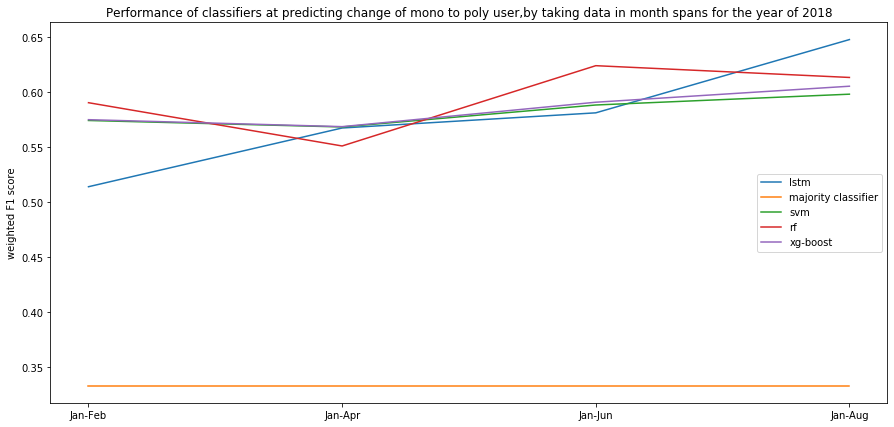

In [135]:
plt.figure(figsize=(15,7))
months = ["Jan-Feb","Jan-Apr","Jan-Jun","Jan-Aug"]
plt.plot(months,lstm_scores,label="lstm")
plt.plot(months,sequence_lstm_scores,label="sequence_lstm")
plt.plot(months,(4*[maj_score]),label="majority classifier")
plt.plot(months,svm_scores,label="svm")
plt.plot(months,rf_scores,label="rf")
plt.plot(months,xgb_scores,label="xg-boost")
plt.title("Performance of classifiers at predicting change of mono to poly user,by taking data in month spans for the year of 2018")
plt.ylabel("weighted F1 score")
plt.legend()
plt.show()

Jan-Feb


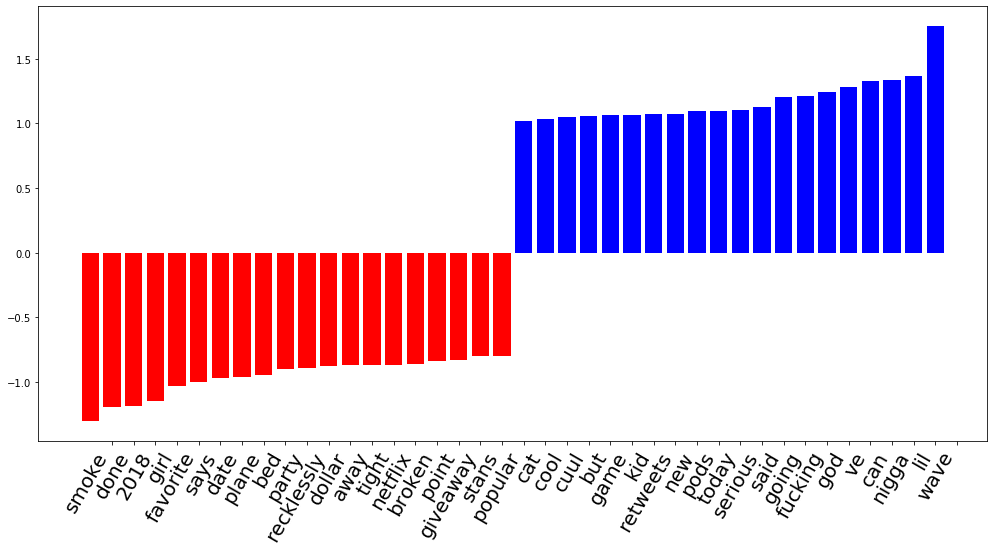

Jan-Apr


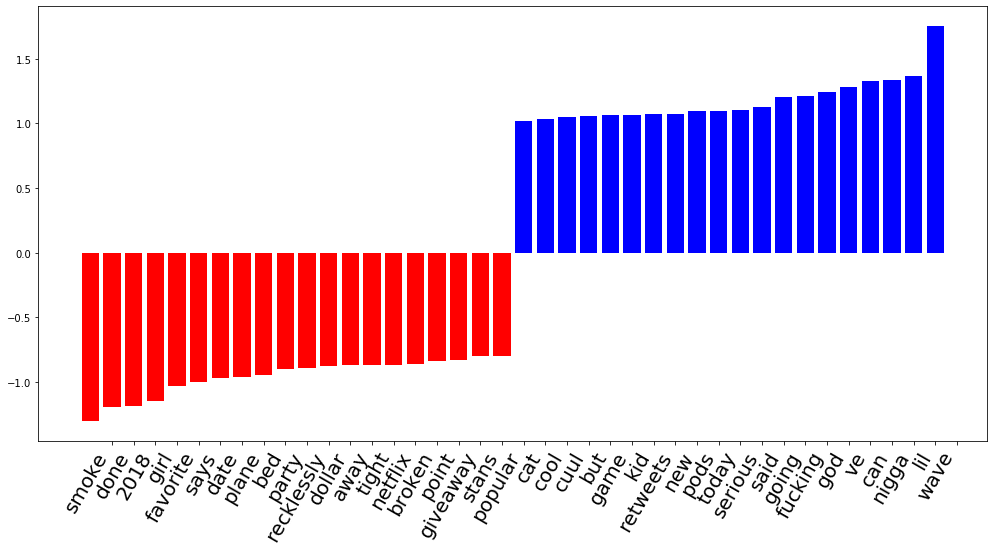

Jan-Jun


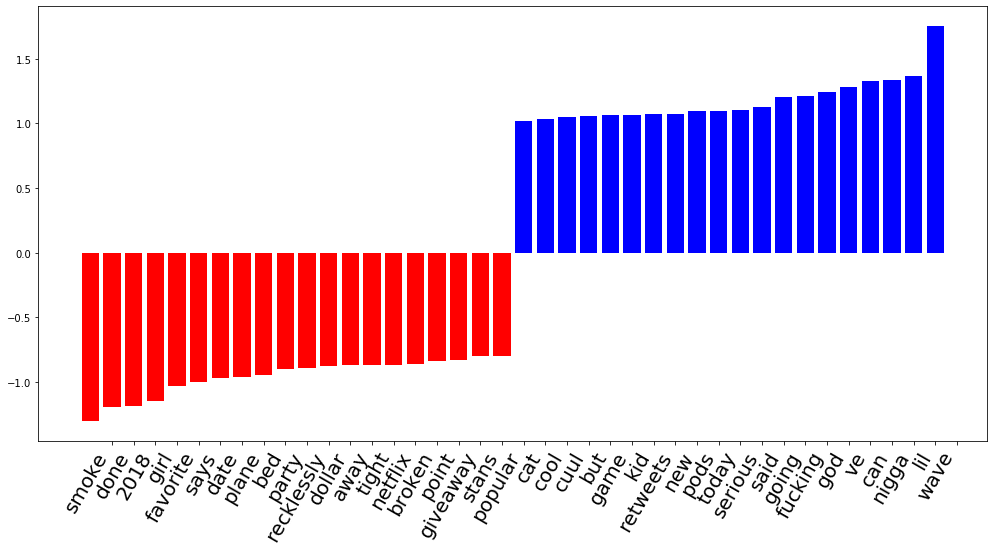

Jan-Aug


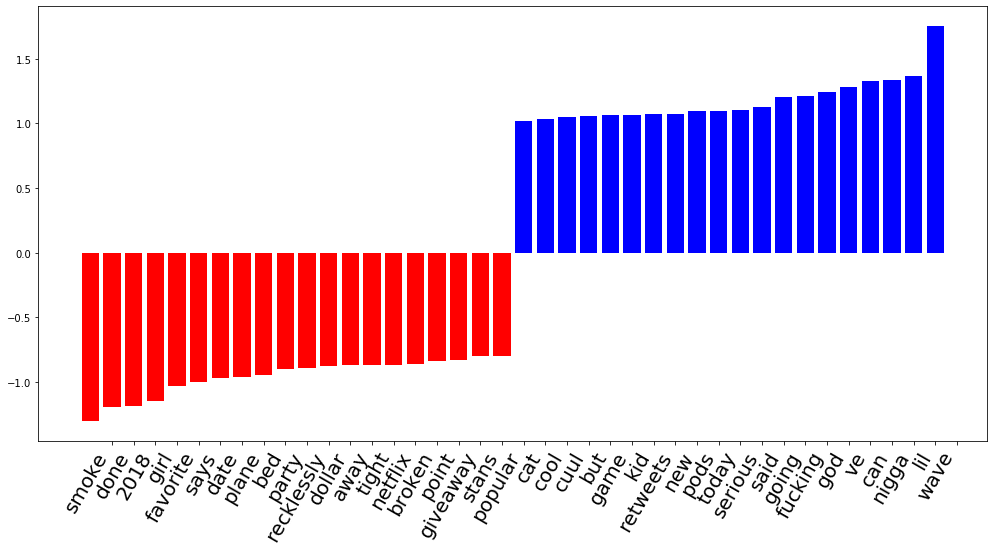

In [240]:
for svm,tf_idf,month in zip(svm_models,tfidf_list,months):
    print(month)
    plot_coeff(20,svm,tf_idf.get_feature_names())

In [777]:
## dump the scores
# with open(os.path.join(input_dir,"sequence_score.pkl"),"wb") as f:
#     pickle.dump(sequence_scores,f)

# with open(os.path.join(input_dir,"sequence_models.pkl"),"wb") as f:
#     pickle.dump(sequence_models,f)
    
# with open(os.path.join(input_dir,"svm_models.pkl"),"wb") as f:
#     pickle.dump(svm_models,f)

# with open(os.path.join(input_dir,"tf_idfs.pkl"),"wb") as f:
#     pickle.dump(tfidf_list,f)

In [526]:
sequence_scores = pickle.load(open(os.path.join(input_dir,"sequence_score.pkl"),"rb"))

In [ ]:
## prepare the tokenizer
print("preparing the tokenizer")
keras_tkzr = keras_Tokenizer()
keras_tkzr.fit_on_texts(data["tweetText"])
vocab_size = len(keras_tkzr.word_index) + 1
print("vocalb",vocab_size)

## embedding matrix
print("creating glove embeddign matrix")
embedding_matrix = get_embedding_matrix(vocab_size,dimension,embedding_file,keras_tkzr)

### looking at sequence of scores in year based interval

## Year level

In [44]:
## lok at the prediction accuracy fo classfier for different range intervals
## 2015 - 
## 2015 -16
## 2015 - 17
## juul_data and first_data
## lstm - sequence, without
## svm
## xgboost ..done

In [25]:
poly_users = pickle.load(open(os.path.join(poly_dir,"poly_users.pkl"),"rb"))
regular_users = pickle.load(open(os.path.join(poly_dir,"regular_users.pkl"),"rb"))
mono_users = pickle.load(open(os.path.join(poly_dir,"mono_users.pkl"),"rb"))

In [26]:
## input data :juul_data 
juul_data = pd.read_csv(os.path.join(input_dir,"juul_data.csv"),lineterminator="\n")
juul_data["tweetCreatedAt"] = pd.to_datetime(juul_data["tweetCreatedAt"])
juul_data = juul_data.loc[juul_data.userID.isin(regular_users)]

# ## look at the weed first and juul_first tweet
first_data = pd.read_csv(os.path.join(input_dir,"user_first.csv"),lineterminator="\n")
first_data = first_data.loc[first_data.userID.isin(regular_users)]  # reg users
first_data["weed_first"] = pd.to_datetime(first_data["weed_first"])
first_data["juul_first"] = pd.to_datetime(first_data["juul_first"])

In [27]:
## removing the rewteet text column completely
ids_ = juul_data.loc[juul_data['retweetText'].notnull()]["tweetId"]
juul_data.loc[juul_data.tweetId.isin(ids_),"tweetText"] = juul_data.loc[juul_data.tweetId.isin(ids_)]["retweetText"]
juul_data = juul_data.drop(["hashtags","retweetText"],axis=1)
len(juul_data) ## 1353987 (sanity check)

1353987

In [28]:
len(juul_data) ## 1353987
len(juul_data.userID.unique()) ## 673724  reg users

673724

In [29]:
## @ returns the data in that year
def get_year_data(year):
    print("year",year)
    users_ = list(first_data["userID"].loc[ 
        ((first_data.juul_first.dt.year <= year)  & (first_data.juul_first.dt.year > (year-1)))
        & ((first_data.weed_first.dt.year == (year + 1)) | (pd.isnull(first_data.weed_first))) ## weed data after 2015
                ]) # users who will change after september

    poly_turn = list(first_data["userID"].loc[
        (first_data.juul_first.dt.year <= year)  & 
        ((first_data.weed_first.dt.year == (year +1 )))]) ## for labelling based on the next year


    print("users that will change",len(poly_turn))
    print("total users",len(users_))

    ## getting the input data
    data_ = juul_data.loc[juul_data.userID.isin(users_)]
    print("length of data",len(data_))

    ## get label - they reamain same for this task as the no of users, we only change the tweets data
    users_ = data_.userID.unique()
    users_lbl = pd.DataFrame(users_,columns=["userID"])
    users_lbl["label"] = 0  ## initialize
    users_lbl.loc[users_lbl.userID.isin(poly_turn) , "label"] = 1
    len(users_lbl.loc[users_lbl.label == 1])  ## sanity check
    return ((year,data_,users_lbl))

In [30]:
## gathering data in different range of intervals
bucket_data = []
bucket_data.append(get_year_data(2015))
bucket_data.append(get_year_data(2016))
bucket_data.append(get_year_data(2017))

year 2015
users that will change 97
total users 1049
length of data 2944
year 2016
users that will change 313
total users 1636
length of data 6475
year 2017
users that will change 9525
total users 40236
length of data 111735


## word2vec - using clusters approach -- dint work

In [31]:
## using spectral clustering
# clustering = SpectralClustering(n_clusters=100,assign_labels="discretize",random_state=0, n_init=10, n_jobs=-1).fit(X)
# ## all the words are coming into one cluster
# len(cluster_dict[0]) ## 5761

## using glove clusters

In [32]:
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")

## using k-means

#### helper functions

In [34]:
## creating X(input array for Kmeans) based on word2vec dimesnions
def get_word2vec_array(model):
    w2v = dict()
    vectors = []
    for ele in (model.wv.vocab):
        w2v[ele] = (model.wv[ele])
        vectors.append(model.wv[ele])
    X = np.array(vectors)
    return X

In [35]:
## get words in each cluster
def get_words_cluster(assigned_cluster,model):
    cluster_dict = {}
    for i,word in enumerate(list(model.wv.vocab)):
        index = assigned_cluster[i]
        cluster_dict[str(word)]  = index
    return cluster_dict

In [36]:
## get unique elements for each element
def get_unigrams(text):
    return (list(set(text)))

In [37]:
# get the vector for each of the user - 100D (100 cluster centers)
## @ returns the cluster vector based on the occurance of words in each cluster ## remove sorted dict
import operator
def get_cluster_vector(tokens,cluster_dict):
    number_of_clusters = len(cluster_dict.keys())
    number_of_tokens = len(tokens)
    
    if not tokens:
        return np.array([0]*number_of_clusters)
    
    cluster_token_count = [0]*number_of_clusters
    for token in tokens:
        cluster_token_count[cluster_dict[token]] += 1
        
    cluster_token_count = [element/number_of_tokens for element in cluster_token_count]
    return np.array(cluster_token_count)

In [38]:
import gensim
import collections
from sklearn import cluster
def get_w2v_kmeans_vector(sentences,n_clusters):
    print("running word2vec")
    model = gensim.models.Word2Vec(
            sentences,
            size=100,
            window=10,
            min_count=1,
            workers=10,
            iter=10)

    ## get word2vec array for based on vocabulary
    print("getting word2vec array")
    X = get_word2vec_array(model)
    
    print("running K-means algorithm")
    ## performing Kmeans
    kmeans = cluster.KMeans(n_clusters=n_clusters,verbose=3)
    kmeans.fit(X)
    labels = kmeans.labels_
    
    print("getting cluster dictionary for word")
    ## getting the cluster dictionary (words in each cluster for vocabulary words)
    cluster_dict = get_words_cluster(labels,model)
    
    print("getting unigrams for sentences")
    ## get unique unigrams from the user
    unigrams = []
    for elements in sentences:
        unigrams.append(get_unigrams(elements))
    
    print("getting the final array")
    ## creating the final X array
    X_final = np.empty((0,n_clusters))
    for tokens in tqdm(unigrams):
        cluster_vector = get_cluster_vector(tokens,cluster_dict) 
    #     print(np.sum(cluster_vector))  ## sanity check
        X_final = np.append(X_final,cluster_vector.reshape(1,-1),axis=0)
    return X_final

In [ ]:
## Runnign Kmeans approach on all of the year data

In [150]:
## preparing the data
svm_scores_cluster = []
rf_scores_cluster = []
xgb_scores_cluster = []
for year,data,users_labelled in bucket_list:
    data["tweetText"] = data["tweetText"].progress_apply(clean_text)
    data = data.groupby(by="userID")["tweetText"].apply(lambda x: "%s" % ' '.join(x)).reset_index()
    data = data.join(users_labelled.set_index("userID"),on="userID",how="inner")
    sentences = data["tweetText"].progress_apply(get_tokens)
    
    X_ = get_w2v_kmeans_vector(sentences,500) ## using k-means cluster label
    y = np.array(list(data["label"]))

    print("downsampling")
    rus = RandomUnderSampler(random_state=0)
    rus.fit(X_,y)
    X_sam, y_sam = rus.fit_sample(X_,y)
    
    
    print("downsampled data length",(X_sam.shape))
    X_train,X_test,Y_train,Y_test  = train_test_split(X_sam, y_sam,test_size =0.20,random_state= 4,shuffle=True ,
                                                       stratify= y_sam)
    
    final = get_baseline_scores(X_train,Y_train, X_test, Y_test)
    svm_model,svm_score = final["svm"]
    rf_model, rf_score = final["rf"]
    xgb_model,xgb_score = final["xg_boost"]
    svm_scores_cluster.append(svm_score)
    svm_scores_cluster.append(rf_score)
    svm_scores_cluster.append(xgb_score)

running word2vec
getting word2vec array
running K-means algorithm
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 5.743506
start iteration
done sorting
end inner loop
Iteration 1, inertia 5.526281
start iteration
done sorting
end inner loop
Iteration 2, inertia 5.487612
start iteration
done sorting
end inner loop
Iteration 3, inertia 5.472686
start iteration
done sorting
end inner loop
Iteration 4, inertia 5.4662256
start iteration
done sorting
end inner loop
Iteration 5, inertia 5.460581
start iteration
done sorting
end inner loop
Iteration 6, inertia 5.4555264
start iteration
done sorting
end inner loop
Iteration 7, inertia 5.453563
start iteration
done sorting
end inner loop
Iteration 8, inertia 5.4523706
start iteration
done sorting
end inner loop
Iteration 9, inertia 5.4519973
start iteration
done sorting
end inner loop
Iteration 10, inertia 5.4517884
start iteration
done sorting
end inner loop
Iteration 11, inertia 5.4516087
start iteratio

done sorting
end inner loop
Iteration 12, inertia 5.455057
start iteration
done sorting
end inner loop
Iteration 13, inertia 5.454975
start iteration
done sorting
end inner loop
Iteration 14, inertia 5.454848
start iteration
done sorting
end inner loop
Iteration 15, inertia 5.454848
center shift 0.000000e+00 within tolerance 1.206293e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 5.7122383
start iteration
done sorting
end inner loop
Iteration 1, inertia 5.5156918
start iteration
done sorting
end inner loop
Iteration 2, inertia 5.4782133
start iteration
done sorting
end inner loop
Iteration 3, inertia 5.4640155
start iteration
done sorting
end inner loop
Iteration 4, inertia 5.4550495
start iteration
done sorting
end inner loop
Iteration 5, inertia 5.45115
start iteration
done sorting
end inner loop
Iteration 6, inertia 5.449104
start iteration
done sorting
end inner loop
Iteration 7, inertia 5.44811
start iteration
done sorting
end inner lo

downsampling
downsampled data length (194, 500)
training the models
svm
[LibLinear]rf
xgBoost
predicting scores
svm
  Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50        20
           1       0.47      0.47      0.47        19

    accuracy                           0.49        39
   macro avg       0.49      0.49      0.49        39
weighted avg       0.49      0.49      0.49        39
 

random_forest
  Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.60      0.52        20
           1       0.38      0.26      0.31        19

    accuracy                           0.44        39
   macro avg       0.42      0.43      0.42        39
weighted avg       0.42      0.44      0.42        39
 

xgboost
  Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.60      0.52        20
           1     

running word2vec
getting word2vec array
running K-means algorithm
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 29.978378
start iteration
done sorting
end inner loop
Iteration 1, inertia 28.94794
start iteration
done sorting
end inner loop
Iteration 2, inertia 28.632544
start iteration
done sorting
end inner loop
Iteration 3, inertia 28.47615
start iteration
done sorting
end inner loop
Iteration 4, inertia 28.374601
start iteration
done sorting
end inner loop
Iteration 5, inertia 28.323145
start iteration
done sorting
end inner loop
Iteration 6, inertia 28.293898
start iteration
done sorting
end inner loop
Iteration 7, inertia 28.258554
start iteration
done sorting
end inner loop
Iteration 8, inertia 28.248344
start iteration
done sorting
end inner loop
Iteration 9, inertia 28.238054
start iteration
done sorting
end inner loop
Iteration 10, inertia 28.230175
start iteration
done sorting
end inner loop
Iteration 11, inertia 28.221598
start iter

end inner loop
Iteration 5, inertia 28.424139
start iteration
done sorting
end inner loop
Iteration 6, inertia 28.381058
start iteration
done sorting
end inner loop
Iteration 7, inertia 28.329832
start iteration
done sorting
end inner loop
Iteration 8, inertia 28.298382
start iteration
done sorting
end inner loop
Iteration 9, inertia 28.274776
start iteration
done sorting
end inner loop
Iteration 10, inertia 28.257177
start iteration
done sorting
end inner loop
Iteration 11, inertia 28.241072
start iteration
done sorting
end inner loop
Iteration 12, inertia 28.235933
start iteration
done sorting
end inner loop
Iteration 13, inertia 28.232822
start iteration
done sorting
end inner loop
Iteration 14, inertia 28.230999
start iteration
done sorting
end inner loop
Iteration 15, inertia 28.227242
start iteration
done sorting
end inner loop
Iteration 16, inertia 28.223335
start iteration
done sorting
end inner loop
Iteration 17, inertia 28.221842
start iteration
done sorting
end inner loop
It

end inner loop
Iteration 6, inertia 28.339418
start iteration
done sorting
end inner loop
Iteration 7, inertia 28.32177
start iteration
done sorting
end inner loop
Iteration 8, inertia 28.304724
start iteration
done sorting
end inner loop
Iteration 9, inertia 28.292078
start iteration
done sorting
end inner loop
Iteration 10, inertia 28.276493
start iteration
done sorting
end inner loop
Iteration 11, inertia 28.254461
start iteration
done sorting
end inner loop
Iteration 12, inertia 28.232435
start iteration
done sorting
end inner loop
Iteration 13, inertia 28.226635
start iteration
done sorting
end inner loop
Iteration 14, inertia 28.219582
start iteration
done sorting
end inner loop
Iteration 15, inertia 28.215906
start iteration
done sorting
end inner loop
Iteration 16, inertia 28.213589
start iteration
done sorting
end inner loop
Iteration 17, inertia 28.211124
start iteration
done sorting
end inner loop
Iteration 18, inertia 28.209572
start iteration
done sorting
end inner loop
It

Iteration 1, inertia 28.805487
start iteration
done sorting
end inner loop
Iteration 2, inertia 28.541721
start iteration
done sorting
end inner loop
Iteration 3, inertia 28.40462
start iteration
done sorting
end inner loop
Iteration 4, inertia 28.333548
start iteration
done sorting
end inner loop
Iteration 5, inertia 28.273642
start iteration
done sorting
end inner loop
Iteration 6, inertia 28.221825
start iteration
done sorting
end inner loop
Iteration 7, inertia 28.187408
start iteration
done sorting
end inner loop
Iteration 8, inertia 28.165186
start iteration
done sorting
end inner loop
Iteration 9, inertia 28.15296
start iteration
done sorting
end inner loop
Iteration 10, inertia 28.14709
start iteration
done sorting
end inner loop
Iteration 11, inertia 28.141233
start iteration
done sorting
end inner loop
Iteration 12, inertia 28.13631
start iteration
done sorting
end inner loop
Iteration 13, inertia 28.131964
start iteration
done sorting
end inner loop
Iteration 14, inertia 28.

downsampling
downsampled data length (518, 500)
training the models
svm
[LibLinear]rf
xgBoost
predicting scores
svm
  Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.48      0.59        52
           1       0.62      0.85      0.72        52

    accuracy                           0.66       104
   macro avg       0.69      0.66      0.65       104
weighted avg       0.69      0.66      0.65       104
 

random_forest
  Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.73      0.64        52
           1       0.63      0.46      0.53        52

    accuracy                           0.60       104
   macro avg       0.60      0.60      0.59       104
weighted avg       0.60      0.60      0.59       104
 

xgboost
  Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.65      0.65        52
           1     

running word2vec
getting word2vec array
running K-means algorithm
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 81521.71
start iteration
done sorting
end inner loop
Iteration 1, inertia 79952.336
start iteration
done sorting
end inner loop
Iteration 2, inertia 79549.234
start iteration
done sorting
end inner loop
Iteration 3, inertia 79414.875
start iteration
done sorting
end inner loop
Iteration 4, inertia 79268.11
start iteration
done sorting
end inner loop
Iteration 5, inertia 79215.44
start iteration
done sorting
end inner loop
Iteration 6, inertia 79161.03
start iteration
done sorting
end inner loop
Iteration 7, inertia 79110.8
start iteration
done sorting
end inner loop
Iteration 8, inertia 79080.13
start iteration
done sorting
end inner loop
Iteration 9, inertia 79043.89
start iteration
done sorting
end inner loop
Iteration 10, inertia 79024.84
start iteration
done sorting
end inner loop
Iteration 11, inertia 79012.195
start iteration
d

end inner loop
Iteration 16, inertia 78846.625
start iteration
done sorting
end inner loop
Iteration 17, inertia 78825.11
start iteration
done sorting
end inner loop
Iteration 18, inertia 78794.555
start iteration
done sorting
end inner loop
Iteration 19, inertia 78773.125
start iteration
done sorting
end inner loop
Iteration 20, inertia 78764.39
start iteration
done sorting
end inner loop
Iteration 21, inertia 78757.84
start iteration
done sorting
end inner loop
Iteration 22, inertia 78750.99
start iteration
done sorting
end inner loop
Iteration 23, inertia 78747.836
start iteration
done sorting
end inner loop
Iteration 24, inertia 78745.625
start iteration
done sorting
end inner loop
Iteration 25, inertia 78744.86
start iteration
done sorting
end inner loop
Iteration 26, inertia 78742.695
start iteration
done sorting
end inner loop
Iteration 27, inertia 78741.16
start iteration
done sorting
end inner loop
Iteration 28, inertia 78740.21
start iteration
done sorting
end inner loop
Iter

Iteration 41, inertia 78975.58
start iteration
done sorting
end inner loop
Iteration 42, inertia 78970.89
start iteration
done sorting
end inner loop
Iteration 43, inertia 78966.56
start iteration
done sorting
end inner loop
Iteration 44, inertia 78962.89
start iteration
done sorting
end inner loop
Iteration 45, inertia 78960.016
start iteration
done sorting
end inner loop
Iteration 46, inertia 78956.45
start iteration
done sorting
end inner loop
Iteration 47, inertia 78951.92
start iteration
done sorting
end inner loop
Iteration 48, inertia 78949.695
start iteration
done sorting
end inner loop
Iteration 49, inertia 78946.516
start iteration
done sorting
end inner loop
Iteration 50, inertia 78944.164
start iteration
done sorting
end inner loop
Iteration 51, inertia 78941.766
start iteration
done sorting
end inner loop
Iteration 52, inertia 78939.67
start iteration
done sorting
end inner loop
Iteration 53, inertia 78938.086
start iteration
done sorting
end inner loop
Iteration 54, inert

Iteration 8, inertia 77825.805
start iteration
done sorting
end inner loop
Iteration 9, inertia 77799.07
start iteration
done sorting
end inner loop
Iteration 10, inertia 77783.766
start iteration
done sorting
end inner loop
Iteration 11, inertia 77779.06
start iteration
done sorting
end inner loop
Iteration 12, inertia 77773.88
start iteration
done sorting
end inner loop
Iteration 13, inertia 77770.59
start iteration
done sorting
end inner loop
Iteration 14, inertia 77761.73
start iteration
done sorting
end inner loop
Iteration 15, inertia 77750.03
start iteration
done sorting
end inner loop
Iteration 16, inertia 77745.37
start iteration
done sorting
end inner loop
Iteration 17, inertia 77743.18
start iteration
done sorting
end inner loop
Iteration 18, inertia 77742.03
start iteration
done sorting
end inner loop
Iteration 19, inertia 77741.18
start iteration
done sorting
end inner loop
Iteration 20, inertia 77739.98
start iteration
done sorting
end inner loop
Iteration 21, inertia 777

end inner loop
Iteration 61, inertia 78793.734
start iteration
done sorting
end inner loop
Iteration 62, inertia 78790.875
start iteration
done sorting
end inner loop
Iteration 63, inertia 78788.31
start iteration
done sorting
end inner loop
Iteration 64, inertia 78786.04
start iteration
done sorting
end inner loop
Iteration 65, inertia 78782.52
start iteration
done sorting
end inner loop
Iteration 66, inertia 78778.25
start iteration
done sorting
end inner loop
Iteration 67, inertia 78775.734
start iteration
done sorting
end inner loop
Iteration 68, inertia 78774.6
start iteration
done sorting
end inner loop
Iteration 69, inertia 78773.24
start iteration
done sorting
end inner loop
Iteration 70, inertia 78772.11
start iteration
done sorting
end inner loop
Iteration 71, inertia 78771.39
start iteration
done sorting
end inner loop
Iteration 72, inertia 78770.38
start iteration
done sorting
end inner loop
Iteration 73, inertia 78769.36
start iteration
done sorting
end inner loop
Iteratio

Iteration 41, inertia 79246.945
start iteration
done sorting
end inner loop
Iteration 42, inertia 79246.91
center shift 3.338782e-03 within tolerance 1.488101e-05
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 81308.54
start iteration
done sorting
end inner loop
Iteration 1, inertia 79039.5
start iteration
done sorting
end inner loop
Iteration 2, inertia 78455.586
start iteration
done sorting
end inner loop
Iteration 3, inertia 78274.625
start iteration
done sorting
end inner loop
Iteration 4, inertia 78184.85
start iteration
done sorting
end inner loop
Iteration 5, inertia 78135.336
start iteration
done sorting
end inner loop
Iteration 6, inertia 78107.695
start iteration
done sorting
end inner loop
Iteration 7, inertia 78098.64
start iteration
done sorting
end inner loop
Iteration 8, inertia 78088.54
start iteration
done sorting
end inner loop
Iteration 9, inertia 78079.37
start iteration
done sorting
end inner loop
Iteration 10, inertia 7807

downsampling
downsampled data length (18612, 500)
training the models
svm
[LibLinear]rf
xgBoost
predicting scores
svm
  Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67      1862
           1       0.67      0.66      0.67      1861

    accuracy                           0.67      3723
   macro avg       0.67      0.67      0.67      3723
weighted avg       0.67      0.67      0.67      3723
 

random_forest
  Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.76      0.69      1862
           1       0.70      0.55      0.61      1861

    accuracy                           0.66      3723
   macro avg       0.66      0.66      0.65      3723
weighted avg       0.66      0.66      0.65      3723
 

xgboost
  Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.73      0.69      1862
           1   

In [91]:
### comparing with SVD

In [151]:
svm_scores

[array([0.57142857, 0.65116279]),
 array([0.44444444, 0.4       ]),
 array([0.5586311 , 0.49481567])]

In [ ]:
svm_scores = []
rf_scores = []
xgb_scores = []
for year,data,users_labelled in bucket_list:
    X_train,Y_train,X_test,Y_test = prepare_data_tfidf(data,users_labelled)
    svd = TruncatedSVD(n_components=500, n_iter=7, random_state=42)
    svd.fit(X_train)  
    X_train = svd.transform(X_train)
    X_test = svd.transform(X_test)
    final = get_baseline_scores(X_train,Y_train,X_test,Y_test)
    svm_model,svm_score = final["svm"]
    rf_model, rf_score = final["rf"]
    xgb_model,xgb_score = final["xg_boost"]
    svm_scores.append(svm_score)
    rf_scores.append(rf_score)
    xgb_scores.append(xgb_score)

## capture user features

In [81]:
## @ return all scores and best model and pred
from sklearn.model_selection import cross_val_score
def get_baseline_scores(X_train,X_test,Y_train,Y_test):
    
    print("training the models")
    print("svm")
    svm = LinearSVC(C=1,verbose=1)
    svm.fit(X_train,Y_train)
    svm_pred = svm.predict(X_test)
    svm_score = precision_recall_fscore_support(Y_test,svm_pred,average=None)[2]  # return the f-score
    svm_f1 =  cross_val_score(svm, X_test, Y_test, cv=5,scoring='f1_macro').mean()
    print('svm cross val score mean',svm_f1,'\n')
    
    print("random_forest")
    rf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
    rf.fit(X_train,Y_train)
    rf_pred = rf.predict(X_test)
    rf_score = precision_recall_fscore_support(Y_test,rf_pred,average=None)[2]
    rf_f1  = cross_val_score(rf, X_test, Y_test, cv=5,scoring='f1_macro').mean()
    print('rf cross val score mean',rf_f1,'\n')
    
    print("xgBoost")
    xgb = XGBClassifier()
    xgb.fit(X_train, Y_train)
    xgb_pred = xgb.predict(X_test)
    xgb_score = precision_recall_fscore_support(Y_test,xgb_pred,average=None)[2]
    xgb_f1 =  cross_val_score(xgb, X_test, Y_test, cv=5,scoring='f1_macro').mean()
    print('xgb corss val score mean',xgb_f1,'\n')
    
    y_pred = [1 for x in range(len(Y_test))]
    maj_score = precision_recall_fscore_support(Y_test,y_pred,average=None)[2]
    
    models = {0:[svm_pred,svm,"svm"], 1:[rf_pred,rf,"rf"] ,2:[xgb_pred,xgb,"xgb"]}
    model_idx = np.argmax([svm_f1,rf_f1,xgb_f1])  ## get the best performing model
    
    print("selecting the best model",models[model_idx][2])

    print("job finished")
    all_scores = {
        'svm': [svm,svm_score],
        'rf' : [rf,rf_score],
        'xg_boost': [xgb,xgb_score],
        'maj': [maj_score],
    }
    return (all_scores,models[model_idx])

In [61]:
def prepare_data(input_data,users_labelled):
    ## preapring the user data
    user_data = input_data.groupby(by="userID").agg({  'tweetText' : 'count',
                                                       'followersCount': 'first',
                                                       'friendsCount' : 'first',
                                                       'statusesCount' : 'first',
                                                       'favourites_count' : 'first',
                                                       'listedCount' : 'first',
                                                      })
    user_data = user_data.rename(columns={'tweetText': 'tweetCount'})
    
    # preapring text
    tweet_data = input_data.groupby(by="userID")["tweetText"].apply(lambda x: "%s" % ' '.join(x)).reset_index()
    ## cleaning the text
    tweet_data["tweetText"] = tweet_data["tweetText"].progress_apply(clean_text)
    tweet_data["tweetText"] = tweet_data["tweetText"].progress_apply(get_tokens).str.join(" ")
    
    ## merging the text and user data
    final_data = user_data.join(tweet_data.set_index("userID"),on="userID",how="inner").reset_index()
    final_data = final_data.fillna(0)   
    
    ## extract the labels
    y = list(final_data.join(users_labelled.set_index("userID"),on="userID",how="inner")["label"]) 
    print("downsampling")
    
    ## downsampling based on userIDS
    userIDs = np.array(list(final_data.userID)).reshape(-1,1)
    rus = RandomUnderSampler(random_state=0)
    rus.fit(userIDs,y)
    userIDs , y_sam = rus.fit_sample(userIDs,y)
    input_data = (final_data.loc[final_data.userID.isin(userIDs.flatten())])
    print("downsampled data length",len(input_data))
    
    print("train-test split")
    train_data,test_data,Y_train,Y_test  = train_test_split(input_data, y_sam,test_size =0.20,random_state= 4,shuffle=True ,
                                                          stratify= y_sam)
    return(train_data,test_data,Y_train,Y_test)

In [41]:
## @ return a trained svm model
def svm_wrapper(X_train,Y_train):
    svm = LinearSVC(C=1, verbose=1)
    svm.fit(X_train, Y_train)
    return svm

In [42]:
def prepare_user_features(input_):
    user_data = input_[["followersCount","friendsCount","statusesCount"
                          ,"favourites_count","listedCount","tweetCount",]]
    ## followerss/ friends ration
    user_data["ff_ratio"] = user_data["followersCount"] / user_data["friendsCount"]

    ## using log of each of the columns
    user_data[["followersCount","friendsCount"
          ,"statusesCount","favourites_count",
          "listedCount"]] = np.log(user_data[["followersCount","friendsCount","statusesCount","favourites_count",
                                        "listedCount"]])
    
    user_data["unigrams"] = list(input_["tweetText"].apply(get_length))

    ## replace the na and inf values 
    user_data = user_data.replace([np.inf, -np.inf], np.nan)
    user_data.replace(np.nan,0)
    user_data = user_data.fillna(0)

    ## normalizing the values
    user_data = (user_data - user_data.min())/(user_data.max()-user_data.min())
    user_data = user_data.replace([np.inf, -np.inf], np.nan)
    user_data = user_data.fillna(0)

    X = user_data.values
    return (X,user_data)

In [43]:
## @ return a trained svm model on user features for LR
## look at the precision scores
## @ returns baseline scores, best model, best model prediction
def run_user_features(train_data,test_data,Y_train,Y_test):
    X_train,_ = prepare_user_features(train_data)
    X_test,_ = prepare_user_features(test_data)
    
    scores,best_model = get_baseline_scores(X_train,X_test,Y_train,Y_test)
    return(scores,best_model[0],best_model[1])

In [170]:
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")
def run_lstm(train_data,test_data,Y_train,Y_test,dimension,epoch,metrics,weight=None):
    scores = []
    ## print winodow , max_len for analysis purpose
    max_len = get_max_length(train_data)
    if max_len > 60:
        max_len = 60
    print("max_length",max_len)

    ## prepare the tokenizer
    print("preparing the tokenizer")
    keras_tkzr = keras_Tokenizer()
    keras_tkzr.fit_on_texts(train_data["tweetText"])
    vocab_size = len(keras_tkzr.word_index) + 1
    print("vocalb",vocab_size)
    
    ## embedding matrix
    print("creating glove embeddign matrix")
    embedding_matrix = get_embedding_matrix(vocab_size,dimension,embedding_file,keras_tkzr) ## tokenizer contains the vocalb info

    ## encoding the docs
    print("encoding the data")
    encoded_docs = keras_tkzr.texts_to_sequences(train_data["tweetText"])
    X_train = (pad_sequences(encoded_docs, maxlen=max_len, padding='post'))

    ## split the data
    print("train-val split")
    X_train,X_val,Y_train,Y_val  = train_test_split(X_train, Y_train,test_size =0.25,random_state= 4,shuffle=True ,
                                                     stratify= Y_train)
    ## encoding the test data
    encoded_docs = keras_tkzr.texts_to_sequences(test_data["tweetText"])
    X_test = (pad_sequences(encoded_docs, maxlen=max_len, padding='post'))
    
    print("X-train",X_train.shape)
    print("X-test",X_test.shape)

    print("creating lstm model")
    model = get_lstm_model(max_len,vocab_size,dimension,embedding_matrix)
    
    print("training the model with balance dataset")
    
    history = model.fit(X_train,Y_train,validation_data = (X_val,Y_val) , nb_epoch = epoch, 
                        verbose = 1,batch_size=32,class_weight= weight,callbacks=[metrics])

    ##plotting trainin validation - no point as we dont want ot look at accuarcy
    training_plot(history)

    kFold = StratifiedKFold(n_splits=3)
    for train, test in kFold.split(X_train, Y_train):
        temp = model.predict(X_train[test])
        y_pred = [np.argmax(value) for value in temp]  ## sigmoid
#         scores.append(get_f1(Y_train[test],y_pred)) ## weighted F1 score
        scores.append(precision_recall_fscore_support(Y_train[test],y_pred,average=None)[2]) ## for each class
        
    print("generating classfication report")
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)
    print('Accuracy: %f' % (accuracy*100))
    ## lstm model
    temp = model.predict(X_test)
    y_pred = [np.argmax(value) for value in temp]  ## sigmoid
    print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')
    
    scores0 = np.array([score[0] for score in scores]).mean()
    scores1 = np.array([score[1] for score in scores]).mean() 
    print("lstm cross val score for mono ",scores0)
    print("lstm cross val score for poly ",scores1)

    print("job finished")
    return ((scores0,scores1),y_pred,model,keras_tkzr,max_len)

In [45]:
## @ return a trained svm model on text features for LR
def run_text_features(train_data,test_data,Y_train,Y_test):
    tf_idf = TfidfVectorizer(sublinear_tf=True)
    tf_idf.fit(train_data["tweetText"])  ## fit on train data
    
     ## transform train and test data
    X_test = tf_idf.transform(test_data["tweetText"])
    X_train = tf_idf.transform(train_data["tweetText"])
    
    
    ## reduce the dimesionality
    svd = TruncatedSVD(n_components=500, n_iter=7, random_state=42)
    svd.fit(X_train)  
    X_train = svd.transform(X_train)
    X_test = svd.transform(X_test)
    
    scores,best_model = get_baseline_scores(X_train,X_test,Y_train,Y_test)
    return (scores,best_model[0],best_model[1],tf_idf,svd)

In [46]:
def cal_text_pred(test_data,Y_test,model,tf_idf,svd):
    X_test = tf_idf.transform(test_data["tweetText"])
    X_test = svd.transform(X_test) ## reduce the dimensionality
    y_pred = model.predict(X_test)
    return y_pred

In [47]:
def cal_lstm_pred(test_data,Y_test,model,keras_tkzr,max_len):
     ## encoding the test data
    encoded_docs = keras_tkzr.texts_to_sequences(test_data["tweetText"])
    X_test = (pad_sequences(encoded_docs, maxlen=max_len, padding='post'))
    ## calculate the model predictions
    temp = model.predict(X_test)
    y_pred = [np.argmax(value) for value in temp]  ## sigmoid
    return y_pred

In [48]:
def cal_user_pred(test_data,Y_test,model):
    X_test,_ = prepare_user_features(test_data)
    y_pred = model.predict(X_test)
    return y_pred

In [82]:
svm_scores = []
rf_scores = []
xgb_scores = []
maj_scores = []
tqdm.pandas()
for year,data,users_labelled in bucket_data:
    print("************")
    print("preparing the data")
    train_data,test_data,Y_train,Y_test = prepare_data(data,users_labelled)
    print("runnning classfier to get user features")
    
    ## user predictions
    scores,user_pred,_ = run_user_features(train_data,test_data,Y_train,Y_test)
    svm_scores.append(scores['svm'][1])
    rf_scores.append(scores['rf'][1])
    xgb_scores.append(scores['xg_boost'][1])
    maj_scores.append(scores['maj'][0])
    ## run textual features..

************
preparing the data



downsampling
downsampled data length 194
train-test split
runnning classfier to get user features
training the models
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]svm cross val score mean 0.4460606060606061 

random_forest
rf cross val score mean 0.3328860028860029 

xgBoost
xgb corss val score mean 0.5504761904761905 

selecting the best model xgb
job finished
************
preparing the data



downsampling
downsampled data length 518
train-test split
runnning classfier to get user features
training the models
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]svm cross val score mean 0.4588347763347763 

random_forest
rf cross val score mean 0.5332479353852351 

xgBoost
xgb corss val score mean 0.5214985641853995 

selecting the best model rf
job finished
************
preparing the data



downsampling
downsampled data length 18612
train-test split
runnning classfier to get user features
training the models
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]svm cross val score mean 0.6560996856703788 

random_forest
rf cross val score mean 0.6558089097475277 

xgBoost
xgb corss val score mean 0.6645965497191659 

selecting the best model xgb
job finished


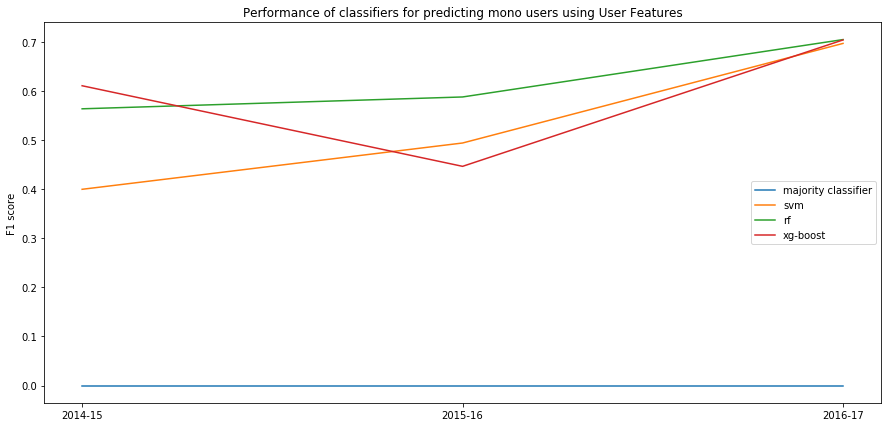

In [83]:
svm = [ele[0] for ele in svm_scores]
rf = [ele[0] for ele in rf_scores]
xgb = [ele[0] for ele in xgb_scores]
maj= [ele[0] for ele in maj_scores]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,(maj),label="majority classifier")
plt.plot(years,svm,label="svm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.title("Performance of classifiers for predicting mono users using User Features")
plt.ylabel("F1 score")
plt.legend()
plt.show()

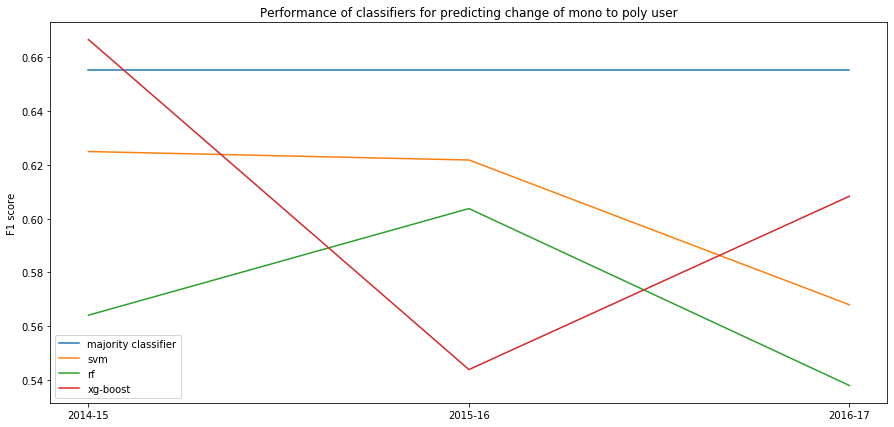

In [85]:
svm = [ele[1] for ele in svm_scores]
rf = [ele[1] for ele in rf_scores]
xgb = [ele[1] for ele in xgb_scores]
maj= [ele[1] for ele in maj_scores]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,3*[maj[0]],label="majority classifier")
plt.plot(years,svm,label="svm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.title("Performance of classifiers for predicting change of mono to poly user")
plt.ylabel("F1 score")
plt.legend()
plt.show()

## looking at just the text features

preparing the data



downsampling
downsampled data length 194
train-test split
runnig classifier to get textual data



max_length 60
preparing the tokenizer
vocalb 1346
creating glove embeddign matrix
encoding the data
train-val split
X-train (87, 60)
X-test (39, 60)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 60)                0         
_________________________________________________________________
embedding_29 (Embedding)     (None, 60, 100)           134600    
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 402       
Total params: 295,802
Trainable params: 295,802
Non-trainable params: 0
_________________________________________________________________
training the model with balance dataset
Train on 87 samples, va

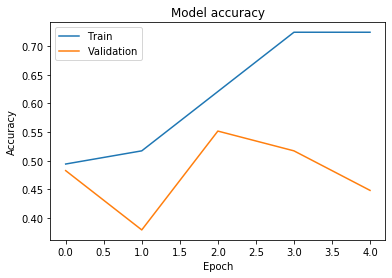

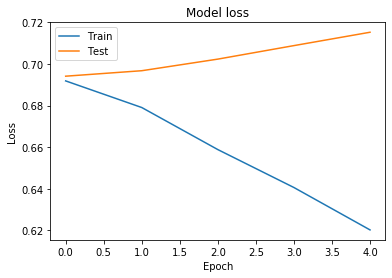

generating classfication report
Accuracy: 43.589744
  Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.25      0.31        20
           1       0.44      0.63      0.52        19

    accuracy                           0.44        39
   macro avg       0.43      0.44      0.42        39
weighted avg       0.43      0.44      0.41        39
 

lstm cross val score for mono  0.6878483835005573
lstm cross val score for poly  0.7863431613431612
job finished
lstm score (0.6878483835005573, 0.7863431613431612)
runnig classifier to get context independent textual data
training the models
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]svm cross val score mean 0.38441558441558443 

random_forest
rf cross val score mean 0.4043867243867244 

xgBoost
xgb corss val score mean 0.35168831168831166 

selecting the best model rf
job finished
training the models
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear


downsampling
downsampled data length 518
train-test split
runnig classifier to get textual data



max_length 60
preparing the tokenizer
vocalb 2759
creating glove embeddign matrix
encoding the data
train-val split
X-train (232, 60)
X-test (104, 60)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 60)                0         
_________________________________________________________________
embedding_30 (Embedding)     (None, 60, 100)           275900    
_________________________________________________________________
bidirectional_30 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 402       
Total params: 437,102
Trainable params: 437,102
Non-trainable params: 0
_________________________________________________________________
training the model with balance dataset
Train on 232 samples,

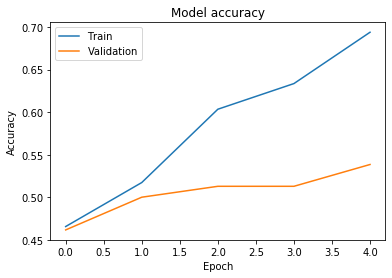

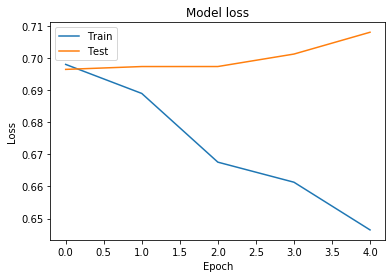

generating classfication report
Accuracy: 47.115385
  Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.48      0.48        52
           1       0.47      0.46      0.47        52

    accuracy                           0.47       104
   macro avg       0.47      0.47      0.47       104
weighted avg       0.47      0.47      0.47       104
 

lstm cross val score for mono  0.7572208798952985
lstm cross val score for poly  0.7311800951041457
job finished
lstm score (0.7572208798952985, 0.7311800951041457)
runnig classifier to get context independent textual data
training the models
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]svm cross val score mean 0.47307329384843183 

random_forest
rf cross val score mean 0.46166914240443646 

xgBoost
xgb corss val score mean 0.5795989974937343 

selecting the best model xgb
job finished
training the models
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinea


downsampling
downsampled data length 18612
train-test split
runnig classifier to get textual data



max_length 60
preparing the tokenizer
vocalb 12040
creating glove embeddign matrix
encoding the data
train-val split
X-train (8374, 60)
X-test (3723, 60)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 60)                0         
_________________________________________________________________
embedding_31 (Embedding)     (None, 60, 100)           1204000   
_________________________________________________________________
bidirectional_31 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_31 (Dense)             (None, 2)                 402       
Total params: 1,365,202
Trainable params: 1,365,202
Non-trainable params: 0
_________________________________________________________________
training the model with balance dataset
Train on 8374 

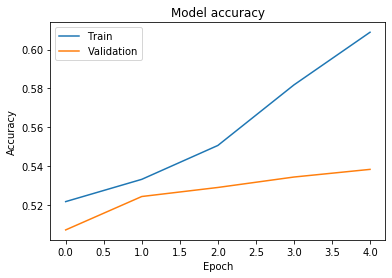

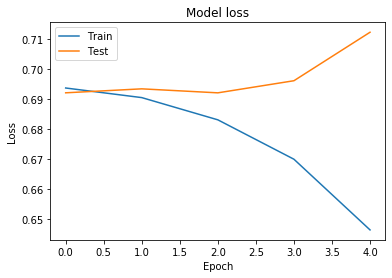

generating classfication report
Accuracy: 53.639538
  Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.44      0.49      1862
           1       0.53      0.63      0.58      1861

    accuracy                           0.54      3723
   macro avg       0.54      0.54      0.53      3723
weighted avg       0.54      0.54      0.53      3723
 

lstm cross val score for mono  0.6475514739210019
lstm cross val score for poly  0.7084985476262254
job finished
lstm score (0.6475514739210019, 0.7084985476262254)
runnig classifier to get context independent textual data
training the models
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]svm cross val score mean 0.5300145849474348 

random_forest
rf cross val score mean 0.5299071861530321 

xgBoost
xgb corss val score mean 0.5256624256992234 

selecting the best model svm
job finished
training the models
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [171]:
svm_scores = []
rf_scores = []
xgb_scores = []
maj_scores = []
lstm_scores = []
for year,data,users_labelled in bucket_data:

    print("preparing the data")
    train_data,test_data,Y_train,Y_test = prepare_data(data,users_labelled)
    train_data,val_data,Y_train,Y_val = train_test_split(train_data,Y_train,test_size =0.25
                                                         ,random_state= 4,shuffle=True)

    print("runnig classifier to get textual data")
    lstm_score,_,_,_,_  = run_lstm(train_data,val_data,Y_train,Y_val,100,5,metrics)
    
    print("lstm score",lstm_score)
                                                                             
    print("runnig classifier to get context independent textual data")
    scores,_,_,_,_ = run_text_features(train_data,val_data,Y_train,Y_val)

    
    ## user predictions
    scores,user_pred,_ = run_user_features(train_data,test_data,Y_train,Y_test)
    svm_scores.append(scores['svm'][1])
    rf_scores.append(scores['rf'][1])
    xgb_scores.append(scores['xg_boost'][1])
    maj_scores.append(scores['maj'][0])
    lstm_scores.append(lstm_score)

In [177]:
lstm_scores = list(set(lstm_scores))

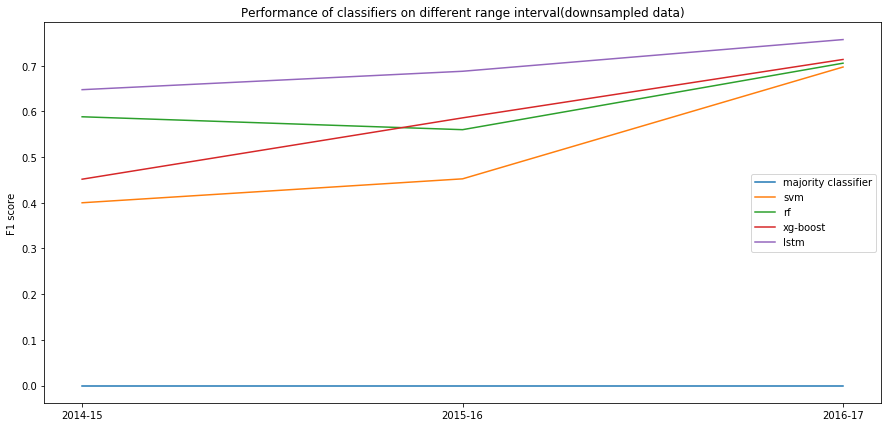

In [181]:
## plotting the graphs
svm = [ele[0] for ele in svm_scores]
rf = [ele[0] for ele in rf_scores]
xgb = [ele[0] for ele in xgb_scores]
maj= [ele[0] for ele in maj_scores]
lstm = [ele[0] for ele in lstm_scores]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,(maj),label="majority classifier")
plt.plot(years,svm,label="svm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.plot(years,lstm,label="lstm")
plt.title("Performance of classifiers on different range interval(downsampled data)")
plt.ylabel("F1 score")
plt.legend()
plt.show()

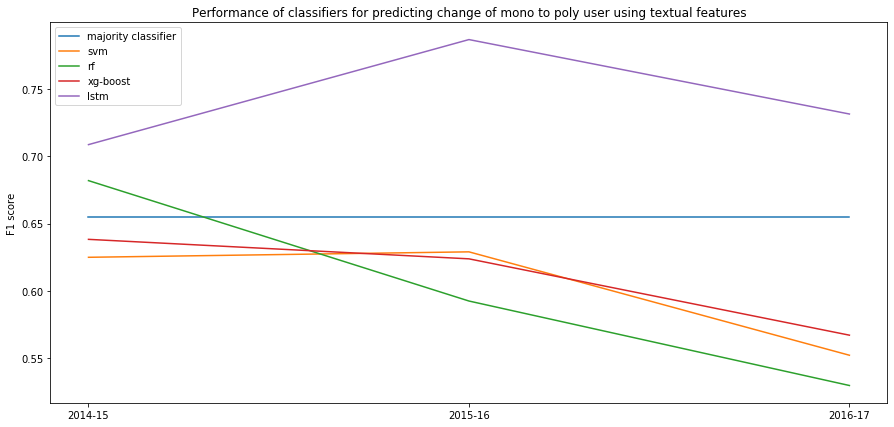

In [180]:
svm = [ele[1] for ele in svm_scores]
rf = [ele[1] for ele in rf_scores]
xgb = [ele[1] for ele in xgb_scores]
maj= [ele[1] for ele in maj_scores]
lstm = [ele[1] for ele in lstm_scores]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,3*[maj[0]],label="majority classifier")
plt.plot(years,svm,label="svm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.plot(years,lstm,label="lstm")
plt.title("Performance of classifiers for predicting change of mono to poly user using textual features")
plt.ylabel("F1 score")
plt.legend()
plt.show()

## Combining user and normal features

In [139]:
from sklearn.linear_model import LogisticRegression

preparing the data



downsampling
downsampled data length 194
train-test split
runnig classifier to get textual data



max_length 60
preparing the tokenizer
vocalb 1346
creating glove embeddign matrix
encoding the data
train-val split
X-train (87, 60)
X-test (39, 60)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 60)                0         
_________________________________________________________________
embedding_23 (Embedding)     (None, 60, 100)           134600    
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 402       
Total params: 295,802
Trainable params: 295,802
Non-trainable params: 0
_________________________________________________________________
training the model with balance dataset
Train on 87 samples, va

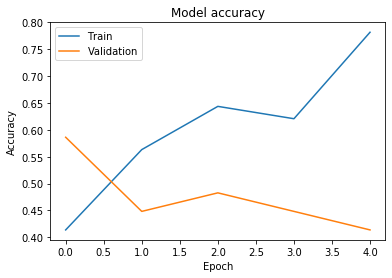

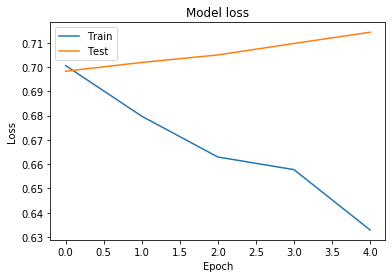

generating classfication report
Accuracy: 41.025641
  Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.45      0.44        20
           1       0.39      0.37      0.38        19

    accuracy                           0.41        39
   macro avg       0.41      0.41      0.41        39
weighted avg       0.41      0.41      0.41        39
 

lstm cross val score for mono  0.7668308702791462
lstm cross val score for poly  0.773504952592828
job finished
runnig classifier to get context independent textual data
training the models
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]svm cross val score mean 0.38441558441558443 

random_forest
rf cross val score mean 0.4043867243867244 

xgBoost
xgb corss val score mean 0.35168831168831166 

selecting the best model rf
job finished
runnning classfier to get user features
training the models
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]s


downsampling
downsampled data length 518
train-test split
runnig classifier to get textual data



max_length 60
preparing the tokenizer
vocalb 2759
creating glove embeddign matrix
encoding the data
train-val split
X-train (232, 60)
X-test (104, 60)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 60)                0         
_________________________________________________________________
embedding_24 (Embedding)     (None, 60, 100)           275900    
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 402       
Total params: 437,102
Trainable params: 437,102
Non-trainable params: 0
_________________________________________________________________
training the model with balance dataset
Train on 232 samples,

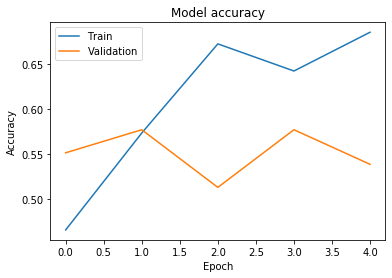

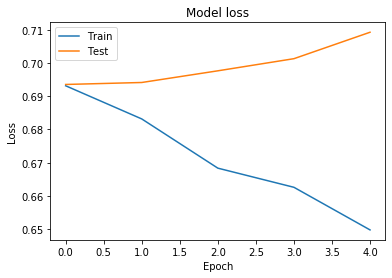

generating classfication report
Accuracy: 51.923077
  Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.44      0.48        52
           1       0.52      0.60      0.55        52

    accuracy                           0.52       104
   macro avg       0.52      0.52      0.52       104
weighted avg       0.52      0.52      0.52       104
 

lstm cross val score for mono  0.7795250017472238
lstm cross val score for poly  0.7716334055574562
job finished
runnig classifier to get context independent textual data
training the models
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]svm cross val score mean 0.47307329384843183 

random_forest
rf cross val score mean 0.46166914240443646 

xgBoost
xgb corss val score mean 0.5795989974937343 

selecting the best model xgb
job finished
runnning classfier to get user features
training the models
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear


downsampling
downsampled data length 18612
train-test split
runnig classifier to get textual data



max_length 60
preparing the tokenizer
vocalb 12040
creating glove embeddign matrix
encoding the data
train-val split
X-train (8374, 60)
X-test (3723, 60)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 60)                0         
_________________________________________________________________
embedding_25 (Embedding)     (None, 60, 100)           1204000   
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_25 (Dense)             (None, 2)                 402       
Total params: 1,365,202
Trainable params: 1,365,202
Non-trainable params: 0
_________________________________________________________________
training the model with balance dataset
Train on 8374 

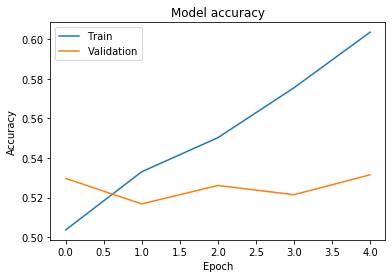

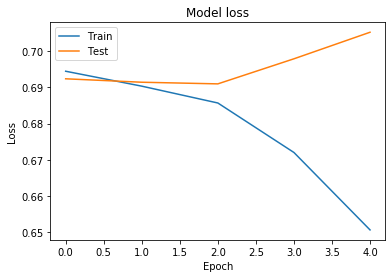

generating classfication report
Accuracy: 53.129197
  Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.59      0.56      1862
           1       0.54      0.47      0.50      1861

    accuracy                           0.53      3723
   macro avg       0.53      0.53      0.53      3723
weighted avg       0.53      0.53      0.53      3723
 

lstm cross val score for mono  0.6731323388778846
lstm cross val score for poly  0.6423999336909945
job finished
runnig classifier to get context independent textual data
training the models
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]svm cross val score mean 0.5300145849474348 

random_forest
rf cross val score mean 0.5299071861530321 

xgBoost
xgb corss val score mean 0.5256624256992234 

selecting the best model svm
job finished
runnning classfier to get user features
training the models
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]s

In [141]:
ensemble_scores = []
maj_scores = []
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")
metrics = Metrics()
pre_predictions= []
list_weights = []
list_Y_test = []

for year,data,users_labelled in bucket_data:

    print("preparing the data")
    train_data,test_data,Y_train,Y_test = prepare_data(data,users_labelled)
    train_data,val_data,Y_train,Y_val = train_test_split(train_data,Y_train,test_size =0.25
                                                         ,random_state= 4,shuffle=True)

    print("runnig classifier to get textual data")
    lstm_scores,lstm_pred,lstm_model,keras_tkzr,max_len  = run_lstm(train_data,val_data,
                                                                             Y_train,Y_val,
                                                                             100,5,metrics)
    print("runnig classifier to get context independent textual data")
    textual_scores,text_pred,text_model,tf_idf,svd = run_text_features(train_data,val_data,Y_train,Y_val)

    print("runnning classfier to get user features")
    ## user predictions
    user_scores,user_pred,user_model = run_user_features(train_data,val_data,Y_train,Y_val)

    ## joining all of the rpedictions for LR
    data = {'user_pred': user_pred, 'texttual': text_pred, 'lstm': lstm_pred}
    df_data = pd.DataFrame(data= data)
    X = df_data.values
    y = Y_val     ## using the validation data
    print("ensemble y val",X.shape)
    print("ensemble y val",len(y))
    lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X,y)
    print(lr.coef_)
    weights = lr.coef_[0]
    list_weights.append(weights)
#     best_idx = np.argmax(lr.coef_[0])
    ## will use the weighst to make prediction on test set

    ## getting predicting on test data
    X_test_lstm = cal_lstm_pred(test_data,Y_test,lstm_model,keras_tkzr,max_len)
    print("X_test lstm",len(X_test_lstm))
    X_test_user = cal_user_pred(test_data,Y_test,user_model)
    print("X_test users", len(X_test_user))
    X_test_text = cal_text_pred(test_data,Y_test,text_model,tf_idf,svd)
    print("X_test ", len(X_test_text))

    ## predicting using the ensemble method on test data
    data = {'user_pred': X_test_user, 'texttual': X_test_text, 'lstm': X_test_lstm}
    df_data = pd.DataFrame(data= data)
    X = df_data.values
    y = Y_test
    print("ensemble y val",X.shape)
    print("ensemble y val",len(y))

    
#     ## max voting idea
#     df_data["pred"] = df_data.sum(axis=1)  # sum to get voting
#     pred = list(df_data["pred"])
    
    ## weighted idea
#     df_data = df_data.mul(list(weights))   # weighted ensemble
#     df_data["pred"] = df_data.sum(axis=1)  # weighted ensemble
#     pred = list(df_data["pred"])
    
    pre_predictions.append((df_data,Y_test,list_weights))

In [161]:
## post predictions changing teh threshold for LR
ensemble_scores = []
maj_scores = []

for df_data,Y_test,weights in pre_predictions:
    ## max voting
    df_data["pred"] = df_data.sum(axis=1)  # sum to get voting
    pred = list(df_data["pred"])
    final_pred = [1 if p >= 2 else 0 for p in pred ]  ## threshold as 0.5
    #     df_data["pred"] = df_data.iloc[:,best_idx]  ## selecting based on max weight
    #     print("best index = ",best_idx)
    #     final_pred = list(df_data["pred"])
    print('  Classification Report ensemble:\n',classification_report(Y_test,final_pred),'\n')
    ensemble_score = precision_recall_fscore_support(Y_test,final_pred,average=None)[2]
    ensemble_scores.append(ensemble_score)

    y_pred = [1 for x in range(len(Y_test))]
    maj_score = precision_recall_fscore_support(Y_test,y_pred,average=None)[2]
    maj_scores.append(maj_score)

  Classification Report ensemble:
               precision    recall  f1-score   support

           0       0.67      0.10      0.17        20
           1       0.50      0.95      0.65        19

    accuracy                           0.51        39
   macro avg       0.58      0.52      0.41        39
weighted avg       0.59      0.51      0.41        39
 

  Classification Report ensemble:
               precision    recall  f1-score   support

           0       0.79      0.21      0.33        52
           1       0.54      0.94      0.69        52

    accuracy                           0.58       104
   macro avg       0.67      0.58      0.51       104
weighted avg       0.67      0.58      0.51       104
 

  Classification Report ensemble:
               precision    recall  f1-score   support

           0       0.67      0.30      0.42      1862
           1       0.55      0.85      0.67      1861

    accuracy                           0.58      3723
   macro avg       

## max voting

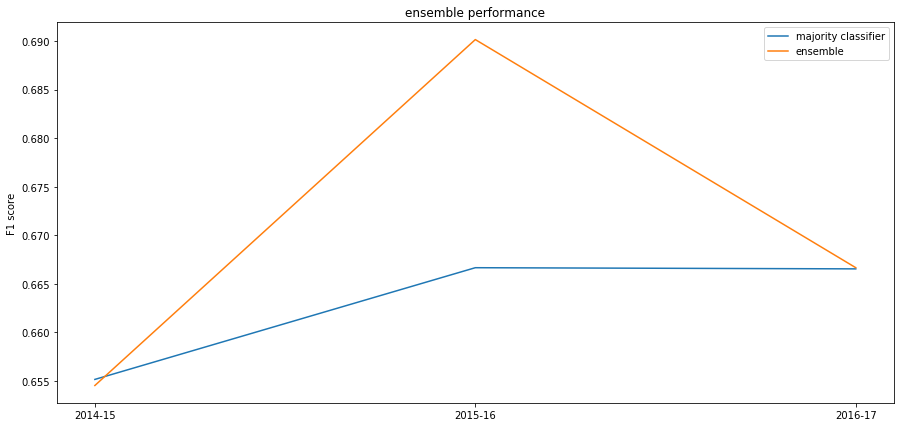

In [162]:
ensemble = [ele[1] for ele in ensemble_scores]
maj= [ele[1] for ele in maj_scores]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,(maj),label="majority classifier")
plt.plot(years,ensemble,label="ensemble")
plt.title("ensemble performance")
plt.ylabel("F1 score")
plt.legend()
plt.show()

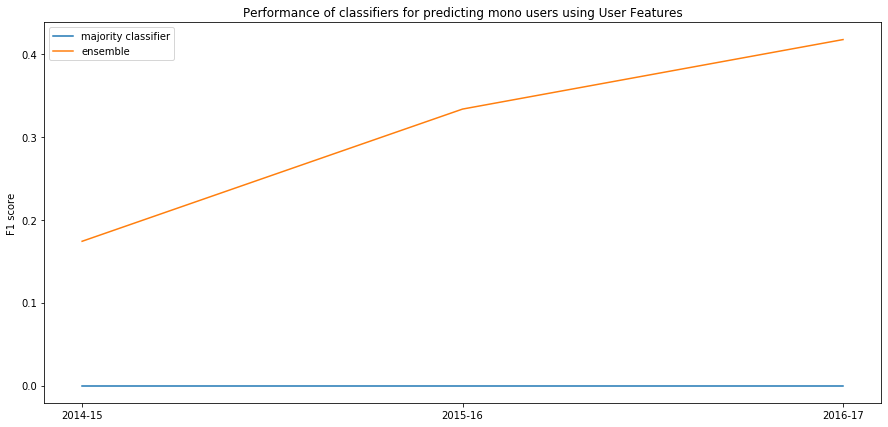

In [163]:
ensemble = [ele[0] for ele in ensemble_scores]
maj= [ele[0] for ele in maj_scores]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,(maj),label="majority classifier")
plt.plot(years,ensemble,label="ensemble")
plt.title("Performance of classifiers for predicting mono users using User Features")
plt.ylabel("F1 score")
plt.legend()
plt.show()

## weighted avergae

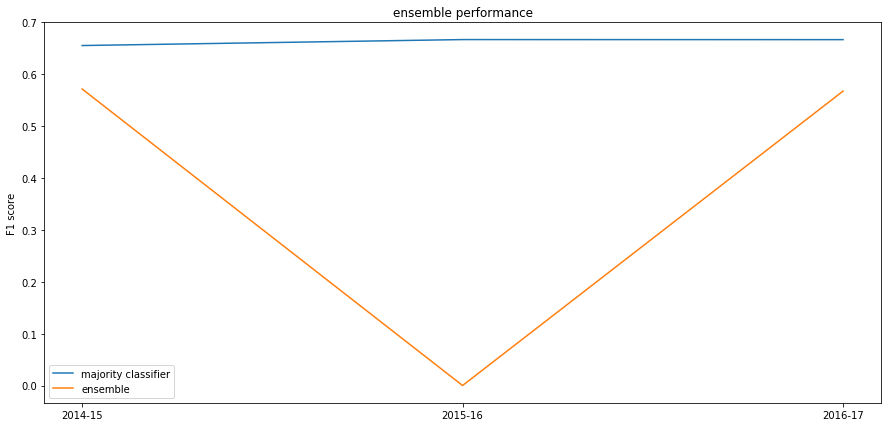

In [122]:
ensemble = [ele[1] for ele in ensemble_scores]
maj= [ele[1] for ele in maj_scores]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,(maj),label="majority classifier")
plt.plot(years,ensemble,label="ensemble")
plt.title("ensemble performance")
plt.ylabel("F1 score")
plt.legend()
plt.show()

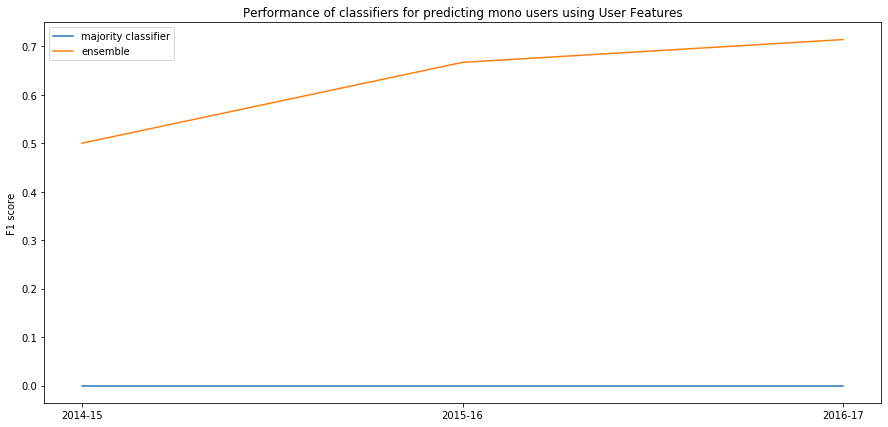

In [679]:
ensemble = [ele[0] for ele in ensemble_scores]
maj= [ele[0] for ele in maj_scores]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,(maj),label="majority classifier")
plt.plot(years,ensemble,label="ensemble")
plt.title("Performance of classifiers for predicting mono users using User Features")
plt.ylabel("F1 score")
plt.legend()
plt.show()

In [ ]:
ensemble = [ele[1] for ele in ensemble_scores]
maj= [ele[1] for ele in maj_scores]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,(maj),label="majority classifier")
plt.plot(years,ensemble,label="ensemble")
plt.title("Performance of classifiers for predicting mono users using User Features")
plt.ylabel("F1 score")
plt.legend()
plt.show()

[0.53485125 0.04940957 0.08564474 0.06018534 0.08759014 0.07345726
 0.06082027 0.04804144]


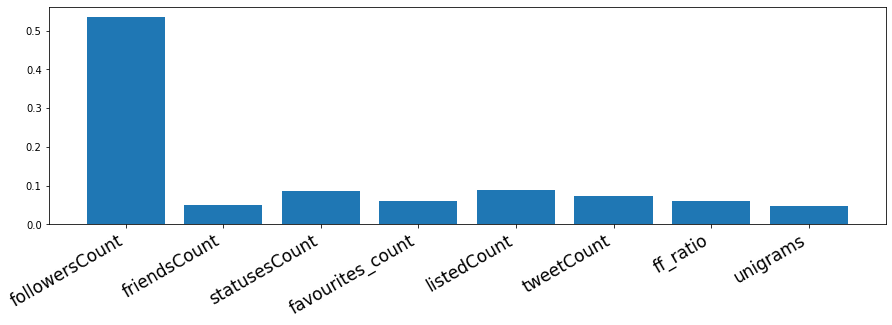

In [523]:
## feature importance for each of the feature
import matplotlib.pyplot as plt
plt.title("feature importance of each of the user features")
print(xgb.feature_importances_)
# plot
plt.figure(figsize=(15,4))
plt.bar(df_test.columns, xgb.feature_importances_)
plt.xticks(rotation='30',ha='right',fontsize=17)
plt.show()

## Sequence models

#### basline models

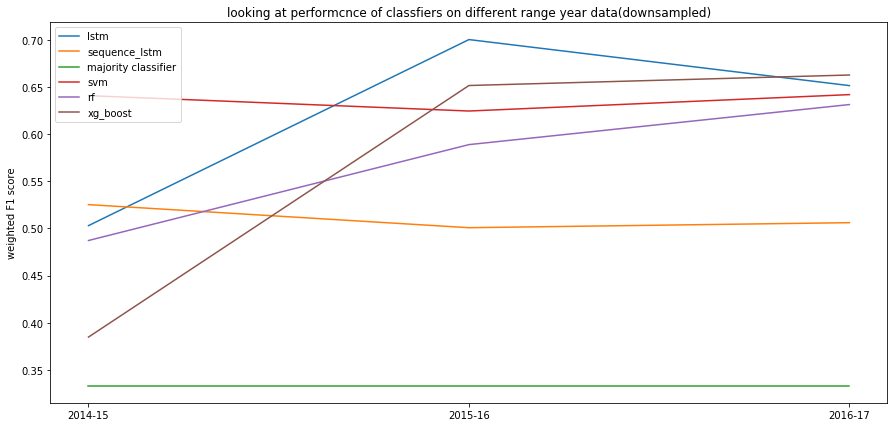

In [77]:
### plot for sequence scores
plt.figure(figsize=(15,7))
spans = ["2014-15","2015-16","2016-17"]
plt.plot(spans,lstm_scores,label="lstm")
plt.plot(spans,sequence_scores,label="sequence_lstm")
plt.plot(spans,(3*[maj_score]),label="majority classifier")
plt.plot(spans,svm_scores,label="svm")
plt.plot(spans,rf_scores,label="rf")
plt.plot(spans,xgb_scores,label="xg_boost")
plt.title("looking at performcnce of classfiers on different range year data(downsampled)")
plt.ylabel("weighted F1 score")
plt.legend()
plt.show()

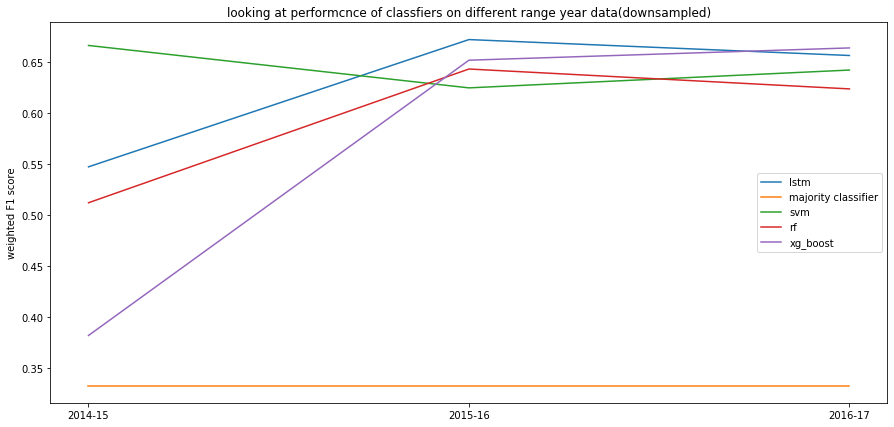

In [91]:
### plot for sequence scores
plt.figure(figsize=(15,7))
spans = ["2014-15","2015-16","2016-17"]
plt.plot(spans,lstm_scores,label="lstm")
plt.plot(spans,(3*[maj_score]),label="majority classifier")
plt.plot(spans,svm_scores,label="svm")
plt.plot(spans,rf_scores,label="rf")
plt.plot(spans,xgb_scores,label="xg_boost")
plt.title("looking at performcnce of classfiers on different range year data(downsampled)")
plt.ylabel("weighted F1 score")
plt.legend()
plt.show()

2014-15


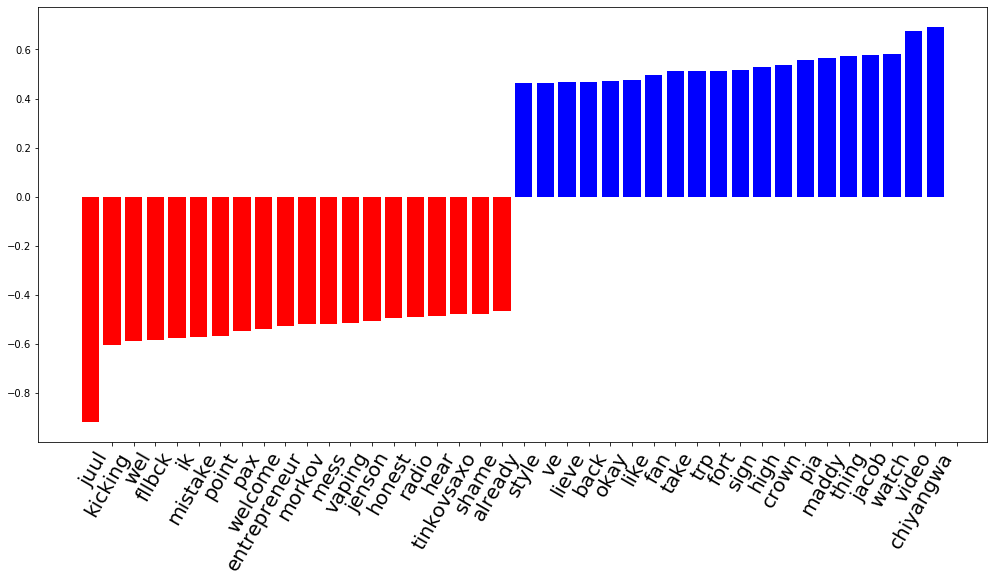

2015-16


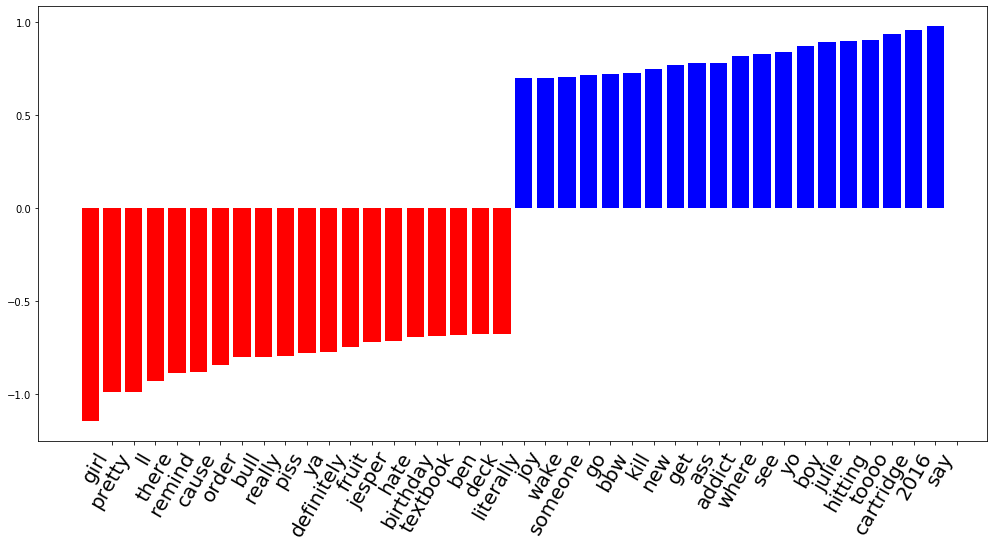

2016-17


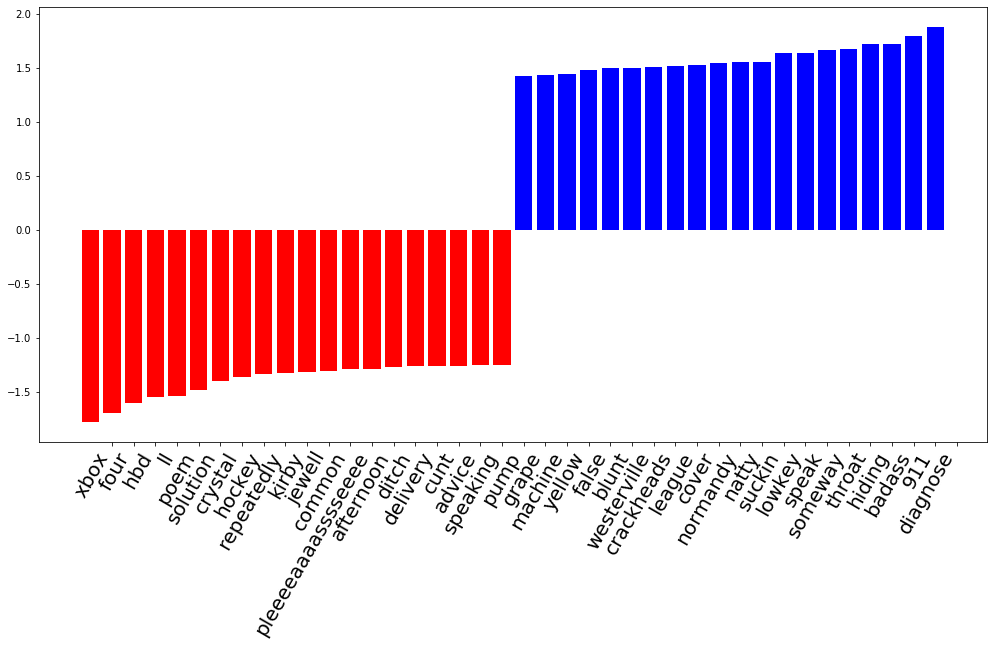

In [53]:
## most descriptive words by year
for svm,tf_idf,year in zip(svm_models,tfidf_list,spans):
    print(year)
    plot_coeff(20,svm,tf_idf.get_feature_names())

### looking at cumulative range of data

In [182]:
bucket_list = []
## bucket 1
## 2014 -15 --
year = 2015
print("year",year)
users_ = list(first_data["userID"].loc[ 
    ((first_data.juul_first.dt.year <= year))
    & ((first_data.weed_first.dt.year == (year + 1)) | (pd.isnull(first_data.weed_first))) ## weed data after 2015
            ]) # users who will change after september

poly_turn = list(first_data["userID"].loc[(first_data.juul_first.dt.year <= year)  
                                        & ((first_data.weed_first.dt.year == (year +1 )))]) ## for labelling based on the next year


print("users that will change",len(poly_turn))
print("total users",len(users_))

## getting the input data
data_ = juul_data.loc[juul_data.userID.isin(users_)]
print("length of data",len(data_))

## get label - they reamain same for this task as the no of users, we only change the tweets data
users_ = data_.userID.unique()
users_lbl = pd.DataFrame(users_,columns=["userID"])
users_lbl["label"] = 0  ## initialize
users_lbl.loc[users_lbl.userID.isin(poly_turn) , "label"] = 1
len(users_lbl.loc[users_lbl.label == 1])  ## sanity check
bucket_list.append((year,data_,users_lbl))

year 2015
users that will change 97
total users 1049
length of data 2944


In [183]:
## bucket 1
## 2014 -16 --
year = 2016
print("year",year)
users_ = list(first_data["userID"].loc[ 
    ((first_data.juul_first.dt.year <= year))
    & ((first_data.weed_first.dt.year == (year + 1)) | (pd.isnull(first_data.weed_first))) ## weed data after 2015
            ]) # users who will change after september

poly_turn = list(first_data["userID"].loc[(first_data.juul_first.dt.year <= year)  
                                        & ((first_data.weed_first.dt.year == (year +1 )))]) ## for labelling based on the next year


print("users that will change",len(poly_turn))
print("total users",len(users_))

## getting the input data
data_ = juul_data.loc[juul_data.userID.isin(users_)]
print("length of data",len(data_))

## get label - they reamain same for this task as the no of users, we only change the tweets data
users_ = data_.userID.unique()
users_lbl = pd.DataFrame(users_,columns=["userID"])
users_lbl["label"] = 0  ## initialize
users_lbl.loc[users_lbl.userID.isin(poly_turn) , "label"] = 1
len(users_lbl.loc[users_lbl.label == 1])  ## sanity check
bucket_list.append((year,data_,users_lbl))

year 2016
users that will change 313
total users 2642
length of data 9456


In [184]:
## bucket 1
## 2014 -17 --
year = 2017
print("year",year)
users_ = list(first_data["userID"].loc[ 
    ((first_data.juul_first.dt.year <= year))
    & ((first_data.weed_first.dt.year == (year + 1)) | (pd.isnull(first_data.weed_first))) ## weed data after 2015
            ]) # users who will change after september

poly_turn = list(first_data["userID"].loc[(first_data.juul_first.dt.year <= year)  
                                        & ((first_data.weed_first.dt.year == (year +1 )))]) ## for labelling based on the next year


print("users that will change",len(poly_turn))
print("total users",len(users_))

## getting the input data
data_ = juul_data.loc[juul_data.userID.isin(users_)]
print("length of data",len(data_))

## get label - they reamain same for this task as the no of users, we only change the tweets data
users_ = data_.userID.unique()
users_lbl = pd.DataFrame(users_,columns=["userID"])
users_lbl["label"] = 0  ## initialize
users_lbl.loc[users_lbl.userID.isin(poly_turn) , "label"] = 1
len(users_lbl.loc[users_lbl.label == 1])  ## sanity check
bucket_list.append((year,data_,users_lbl))

year 2017
users that will change 9525
total users 42784
length of data 120873


preparing the data



downsampling
downsampled data length 194
train-test split
runnig classifier to get textual data



max_length 60
preparing the tokenizer
vocalb 1346
creating glove embeddign matrix
encoding the data
train-val split
X-train (87, 60)
X-test (39, 60)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        (None, 60)                0         
_________________________________________________________________
embedding_32 (Embedding)     (None, 60, 100)           134600    
_________________________________________________________________
bidirectional_32 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 402       
Total params: 295,802
Trainable params: 295,802
Non-trainable params: 0
_________________________________________________________________
training the model with balance dataset
Train on 87 samples, va

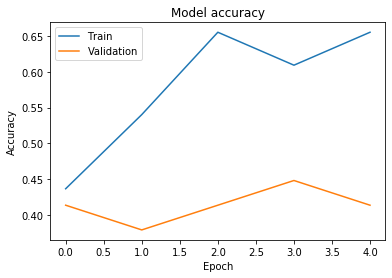

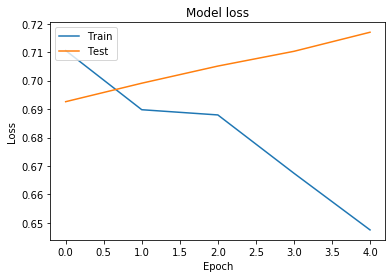

generating classfication report
Accuracy: 41.025641
  Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.35      0.38        20
           1       0.41      0.47      0.44        19

    accuracy                           0.41        39
   macro avg       0.41      0.41      0.41        39
weighted avg       0.41      0.41      0.41        39
 

lstm cross val score for mono  0.7117168928763132
lstm cross val score for poly  0.7717924821373098
job finished
lstm score (0.7117168928763132, 0.7717924821373098)
runnig classifier to get context independent textual data
training the models
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]svm cross val score mean 0.38441558441558443 

random_forest
rf cross val score mean 0.4043867243867244 

xgBoost
xgb corss val score mean 0.35168831168831166 

selecting the best model rf
job finished
training the models
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear


downsampling
downsampled data length 518
train-test split
runnig classifier to get textual data



max_length 60
preparing the tokenizer
vocalb 2759
creating glove embeddign matrix
encoding the data
train-val split
X-train (232, 60)
X-test (104, 60)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 60)                0         
_________________________________________________________________
embedding_33 (Embedding)     (None, 60, 100)           275900    
_________________________________________________________________
bidirectional_33 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_33 (Dense)             (None, 2)                 402       
Total params: 437,102
Trainable params: 437,102
Non-trainable params: 0
_________________________________________________________________
training the model with balance dataset
Train on 232 samples,

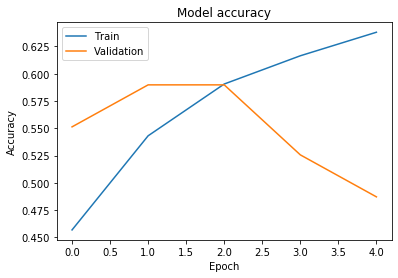

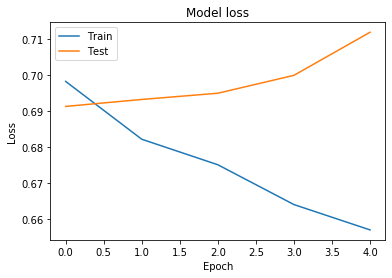

generating classfication report
Accuracy: 61.538462
  Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.56      0.59        52
           1       0.60      0.67      0.64        52

    accuracy                           0.62       104
   macro avg       0.62      0.62      0.61       104
weighted avg       0.62      0.62      0.61       104
 

lstm cross val score for mono  0.6976397515527951
lstm cross val score for poly  0.7123555952203877
job finished
lstm score (0.6976397515527951, 0.7123555952203877)
runnig classifier to get context independent textual data
training the models
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]svm cross val score mean 0.47307329384843183 

random_forest
rf cross val score mean 0.46166914240443646 

xgBoost
xgb corss val score mean 0.5795989974937343 

selecting the best model xgb
job finished
training the models
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinea


downsampling
downsampled data length 18612
train-test split
runnig classifier to get textual data



max_length 60
preparing the tokenizer
vocalb 12040
creating glove embeddign matrix
encoding the data
train-val split
X-train (8374, 60)
X-test (3723, 60)
creating lstm model
creating model
compiling the model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 60)                0         
_________________________________________________________________
embedding_34 (Embedding)     (None, 60, 100)           1204000   
_________________________________________________________________
bidirectional_34 (Bidirectio (None, 200)               160800    
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 402       
Total params: 1,365,202
Trainable params: 1,365,202
Non-trainable params: 0
_________________________________________________________________
training the model with balance dataset
Train on 8374 

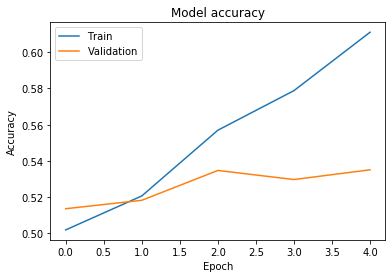

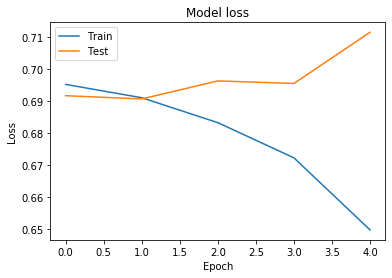

generating classfication report
Accuracy: 52.726296
  Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.35      0.42      1862
           1       0.52      0.71      0.60      1861

    accuracy                           0.53      3723
   macro avg       0.53      0.53      0.51      3723
weighted avg       0.53      0.53      0.51      3723
 

lstm cross val score for mono  0.606862049387283
lstm cross val score for poly  0.7148339856439178
job finished
lstm score (0.606862049387283, 0.7148339856439178)
runnig classifier to get context independent textual data
training the models
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]svm cross val score mean 0.5300145849474348 

random_forest
rf cross val score mean 0.5299071861530321 

xgBoost
xgb corss val score mean 0.5256624256992234 

selecting the best model svm
job finished
training the models
svm
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][L

In [185]:
## RNN (LSTM)
embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")
svm_scores = []
rf_scores = []
xgb_scores = []
maj_scores = []
lstm_scores = []
for year,data,users_labelled in bucket_data:

    print("preparing the data")
    train_data,test_data,Y_train,Y_test = prepare_data(data,users_labelled)
    train_data,val_data,Y_train,Y_val = train_test_split(train_data,Y_train,test_size =0.25
                                                         ,random_state= 4,shuffle=True)

    print("runnig classifier to get textual data")
    lstm_score,_,_,_,_  = run_lstm(train_data,val_data,Y_train,Y_val,100,5,metrics)
    
    print("lstm score",lstm_score)
                                                                             
    print("runnig classifier to get context independent textual data")
    scores,_,_,_,_ = run_text_features(train_data,val_data,Y_train,Y_val)

    
    ## user predictions
    scores,user_pred,_ = run_user_features(train_data,test_data,Y_train,Y_test)
    svm_scores.append(scores['svm'][1])
    rf_scores.append(scores['rf'][1])
    xgb_scores.append(scores['xg_boost'][1])
    maj_scores.append(scores['maj'][0])
    lstm_scores.append(lstm_score)

### Plots for cumulative range

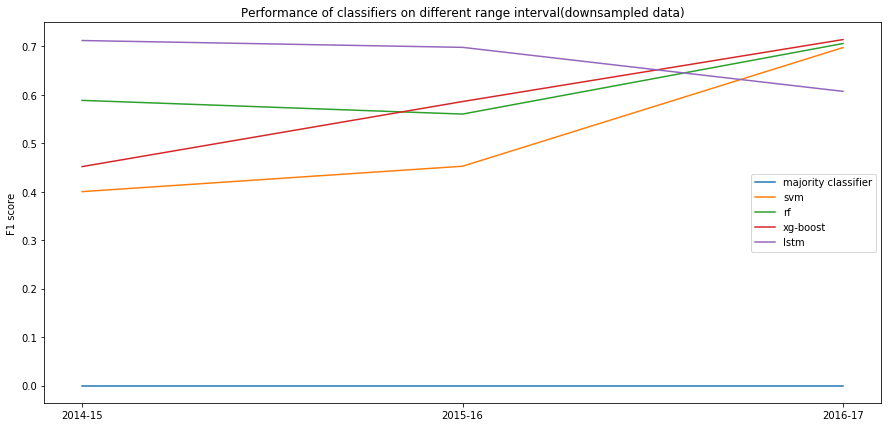

In [186]:
## plotting the graphs
svm = [ele[0] for ele in svm_scores]
rf = [ele[0] for ele in rf_scores]
xgb = [ele[0] for ele in xgb_scores]
maj= [ele[0] for ele in maj_scores]
lstm = [ele[0] for ele in lstm_scores]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,(maj),label="majority classifier")
plt.plot(years,svm,label="svm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.plot(years,lstm,label="lstm")
plt.title("Performance of classifiers on different range interval(downsampled data)")
plt.ylabel("F1 score")
plt.legend()
plt.show()

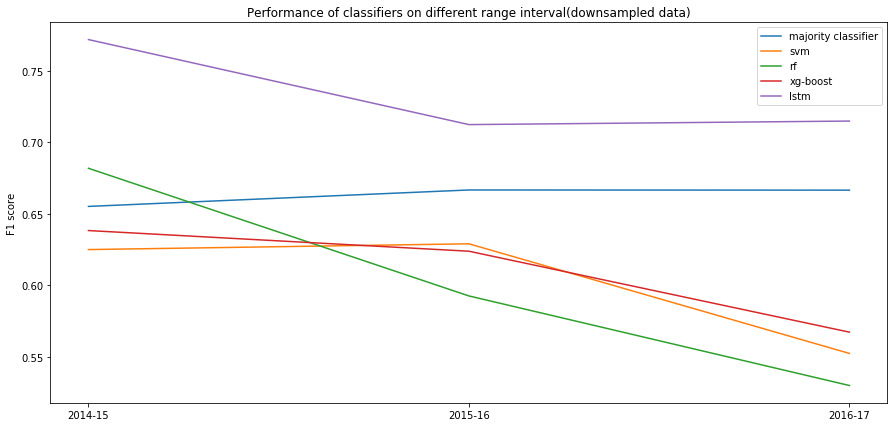

In [187]:
## plotting the graphs
svm = [ele[1] for ele in svm_scores]
rf = [ele[1] for ele in rf_scores]
xgb = [ele[1] for ele in xgb_scores]
maj= [ele[1] for ele in maj_scores]
lstm = [ele[1] for ele in lstm_scores]
## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,(maj),label="majority classifier")
plt.plot(years,svm,label="svm")
plt.plot(years,rf,label="rf")
plt.plot(years,xgb,label="xg-boost")
plt.plot(years,lstm,label="lstm")
plt.title("Performance of classifiers on different range interval(downsampled data)")
plt.ylabel("F1 score")
plt.legend()
plt.show()

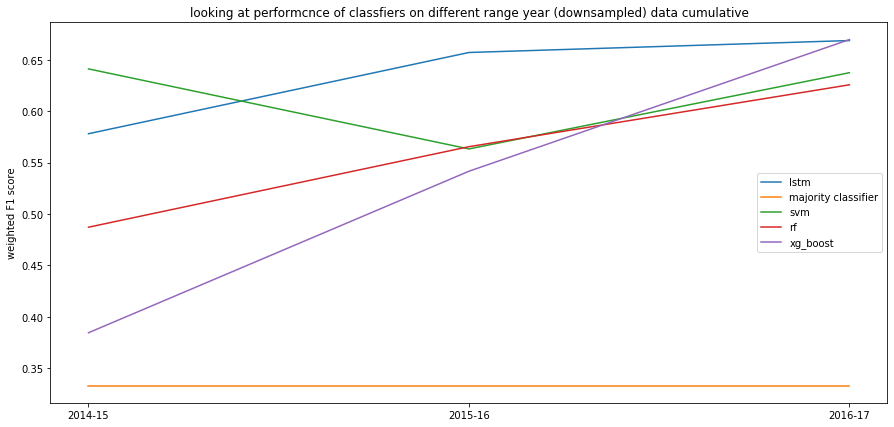

In [97]:
## old plot
### plot with cumulative data
plt.figure(figsize=(15,7))
spans = ["2014-15","2014-16","2014-17"]
plt.plot(spans,lstm_scores,label="lstm")
plt.plot(spans,(3*[maj_score]),label="majority classifier")
plt.plot(spans,svm_scores,label="svm")
plt.plot(spans,rf_scores,label="rf")
plt.plot(spans,xgb_scores,label="xg_boost")
plt.title("looking at performcnce of classfiers on different range year (downsampled) data cumulative")
plt.ylabel("weighted F1 score")
plt.legend()
plt.show()

2014-15


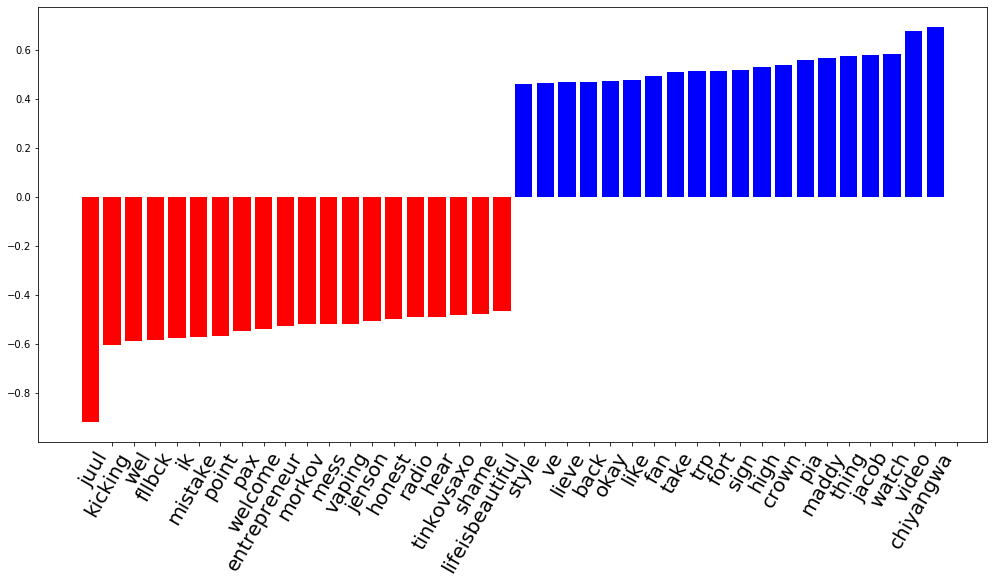

2015-16


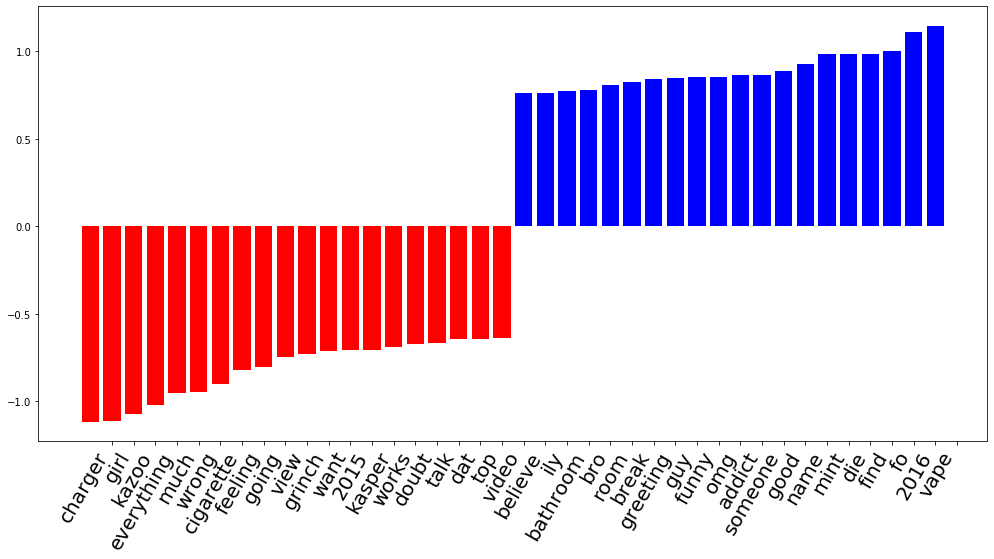

2016-17


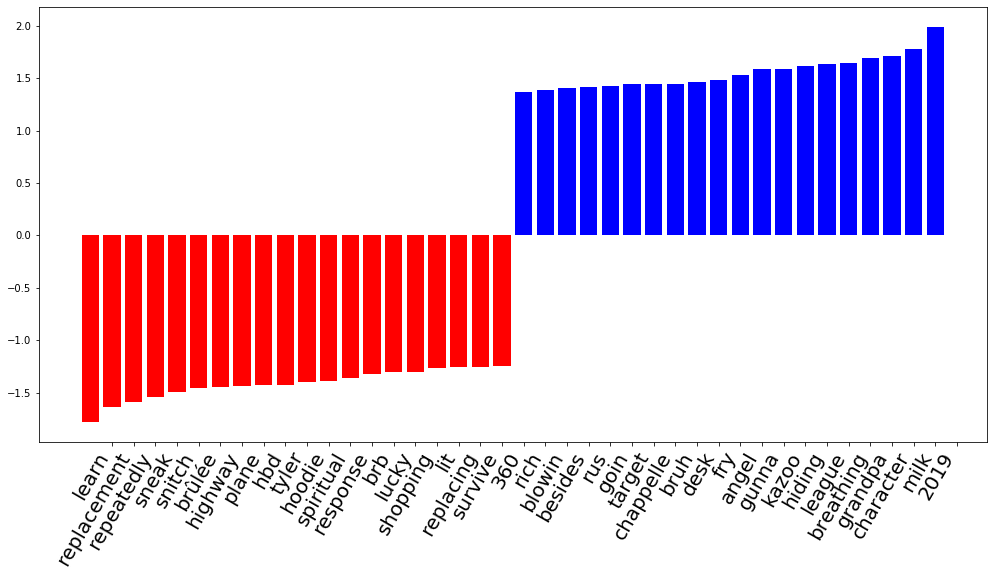

In [98]:
## most descriptive words by year
for svm,tf_idf,year in zip(svm_models,tfidf_list,spans):
    print(year)
    plot_coeff(20,svm,tf_idf.get_feature_names())